In [152]:
import pandas as pd
import numpy as np
import pandas_profiling.profile_report as report

import re
import seaborn as sns
sns.set(style = 'white')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick # For specifying the axes tick format 

import warnings
warnings.filterwarnings('ignore')

# Label Encoding - 문자열의 unique값을 숫자로 바꿔주는 방법.
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import StackingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import tensorflow as tf

# 1. 데이터 확인

In [2]:
# df = pd.read_csv('./모델링시작.csv', encoding='euc-kr') # 이건 컬럼들 몇개 없앤 것.

In [153]:
df = pd.read_csv('./telecom_customer_churn.csv',encoding='euc-kr') # 이게 순정

In [3]:
df_new = pd.read_csv('./telecom_customer_churn.csv',encoding='euc-kr') # 이게 순정

# 2. 데이터 전처리

#### Columns Prep

In [154]:
# 변수명 변경
df.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)

In [5]:
df_new.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)

In [155]:
df.columns 

Index(['customer_id', 'gender', 'age', 'married', 'number_of_dependents',
       'city', 'zip_code', 'latitude', 'longitude', 'number_of_referrals',
       'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn_category', 'churn_reason'],
      dtype='object')

In [7]:
# drop no need cols 컬럼들 제거
df = df.drop(['city', 'zip_code', 'latitude', 'longitude'], axis = 1) 

In [7]:
# # create tenure_in_years col 
# df['tenure_in_years'] = 0
# df.loc[(df['tenure_in_months'] <= 12), 'tenure_in_years'] = '1'
# df.loc[(df['tenure_in_months'] > 12) & (df['tenure_in_months']  <= 24), 'tenure_in_years'] = '2'
# df.loc[(df['tenure_in_months'] > 24) & (df['tenure_in_months'] <= 36), 'tenure_in_years'] = '3'
# df.loc[(df['tenure_in_months'] > 36) & (df['tenure_in_months'] <= 48), 'tenure_in_years'] = '4'
# df.loc[(df['tenure_in_months'] > 48) & (df['tenure_in_months'] <= 60), 'tenure_in_years'] = '5'
# df.loc[df['tenure_in_months'] > 60, 'tenure_in_years'] = '6'
# df = df.astype({'tenure_in_years': 'int'})
# df['tenure_in_years'].value_counts()

1    2186
6    1407
2    1024
5     832
3     832
4     762
Name: tenure_in_years, dtype: int64

#### 'churn' col (binary variables)

In [156]:
df['churn'] = np.where(df['customer_status'] == 'Churned', 'Yes', 'No')

In [9]:
df_new['churn'] = np.where(df['customer_status'] == 'Churned', 'Yes', 'No')

Y값을 보기 쉽게 바꾸어 준 것. yes no 분류만 해주면 의미가 통하기에

## 2-2.결측치

#### check for missing values

In [157]:
# df.isnull().sum()
df.isnull().sum().to_frame('nan_count')

,nan_count
customer_id,0
gender,0
age,0
married,0
number_of_dependents,0
city,0
zip_code,0
latitude,0
longitude,0
number_of_referrals,0


In [158]:
df['avg_monthly_long_distance_charges'] = df['avg_monthly_long_distance_charges'].fillna(df['avg_monthly_long_distance_charges'].mean())

In [159]:
df_new['avg_monthly_long_distance_charges'] = df['avg_monthly_long_distance_charges'].fillna(df['avg_monthly_long_distance_charges'].mean())

In [160]:
df.multiple_lines = df.multiple_lines.fillna('No Phone Service')
df_new.multiple_lines = df.multiple_lines.fillna('No Phone Service')

#### Nulls of features that are related to 'Internet Service'

In [161]:
no_internet_service = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan','premium_tech_support',
                       'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet_service] = df[no_internet_service].fillna('No Internet Service')

df_new[no_internet_service] = df[no_internet_service].fillna('No Internet Service')

In [ ]:
# 인터넷 서비스와 전부 종속인 컬럼이므로 안쓰는 애들은 전부 하나의 문자열로 통합.
# 나중에 레이블 인코딩과 관련.

In [162]:
df['avg_monthly_gb_download'] = df['avg_monthly_gb_download'].fillna(df['avg_monthly_gb_download'].mean())
df_new['avg_monthly_gb_download'] = df['avg_monthly_gb_download'].fillna(df['avg_monthly_gb_download'].mean())

- **Features that are correlated with 'Internet Service' = list of *no_internet_service*.**
- **Internet Service-related columns are filled as either mean value or string 'No internet service'.**

#### Nulls of object columns to 'None'

- **Missing values of 'Churn Category' and 'Churn Reason' are filled as *None* as their datatype is object.**
- 일단 생략하는 이유: 이후 churning reasons 뽑을 때 분석 방해

# 3. 데이터 시각화 / EDA

In [16]:
df.groupby('churn')['monthly_charge'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
No,5174.0,60.073618,32.056245,-10.0,24.8,63.2,87.5,118.75
Yes,1869.0,73.347592,26.373764,-10.0,55.3,79.5,94.2,118.35


In [17]:
df.groupby('churn')['monthly_charge']
df['monthly_charge']

0       65.60
1       -4.00
2       73.90
3       98.00
4       83.90
        ...  
7038    55.15
7039    85.10
7040    50.30
7041    67.85
7042    59.00
Name: monthly_charge, Length: 7043, dtype: float64

In [56]:
df.groupby(['churn', 'gender'])['monthly_charge'].describe()
# 0이 남자 1이 여자

count       mean        std   min     25%   50%     75%     max
churn gender                                                                  
0     0       2549.0  60.773696  31.912681 -10.0  25.000  64.0  88.400  118.75
      1       2625.0  59.393810  32.186544 -10.0  24.600  62.1  86.750  118.20
1     0        939.0  73.606656  26.093400 -10.0  59.625  79.5  93.625  117.45
      1        930.0  73.086022  26.665339  -9.0  53.875  79.5  94.500  118.35

In [20]:
df.groupby('churn')['total_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
No,5174.0,2550.792103,2329.091754,18.80,574.3875,1679.525,4262.85,8672.45
Yes,1869.0,1531.796094,1890.822994,18.85,134.5000,703.550,2331.30,8684.80


In [59]:
df_churn = df[df['churn'] == 1]
df_churn.describe() # 이탈한 고객들만 보고자 할 때 데이터 분리 복사
df_churn['monthly_charge'].describe()

count    1869.000000
mean       73.347592
std        26.373764
min       -10.000000
25%        55.300000
50%        79.500000
75%        94.200000
max       118.350000
Name: monthly_charge, dtype: float64

In [ ]:
# 전체 비용은 이탈여부로 나누기엔 표본수 차이가 심하다.
# 표본 수 차이가 심하더라도 이탈하지 않은 고객들이 평균 비용을 훨씬 많이 들었다.

## 이탈 이유

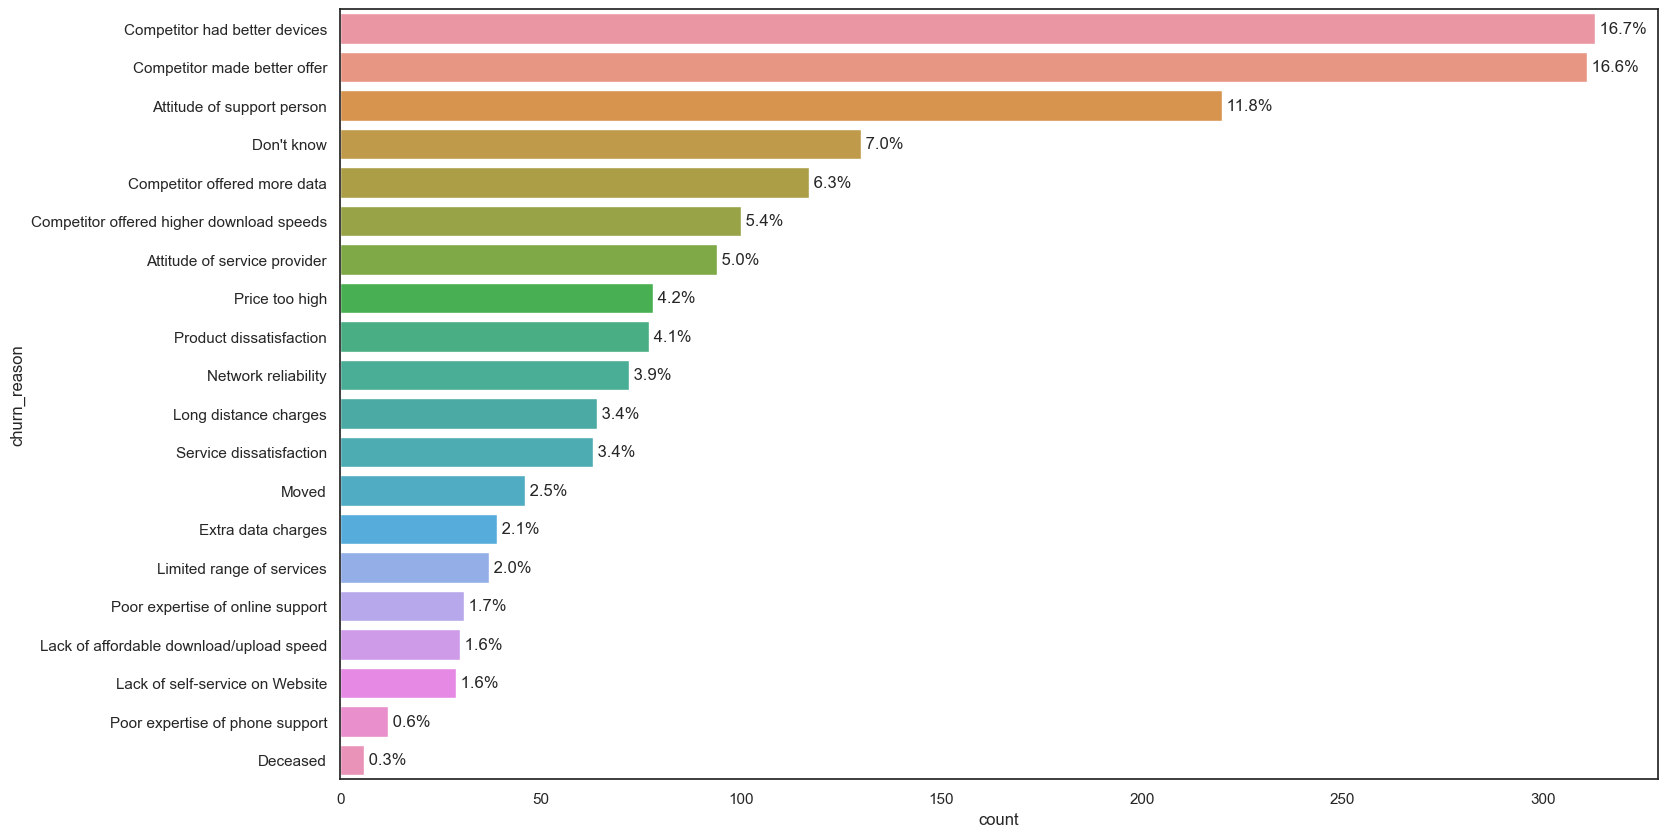

In [20]:
# sns.countplot(data = df, y = 'churn_reason', order = df['churn_reason'].value_counts().index)
# order 사용하여 내림차순으로 정렬

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17,10))
churn_reason = df['churn_reason'].dropna()
sns.countplot(data=df, y=churn_reason, ax=ax, order=df['churn_reason'].value_counts().index)
total = len(churn_reason)
for p in ax.patches: # ax.patches : 그래프 위에 비율 쓰고 싶을 때 사용하는 메소드
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(' '+percentage, (x,y), ha='left', va='center', fontsize=12)
plt.show()
# good

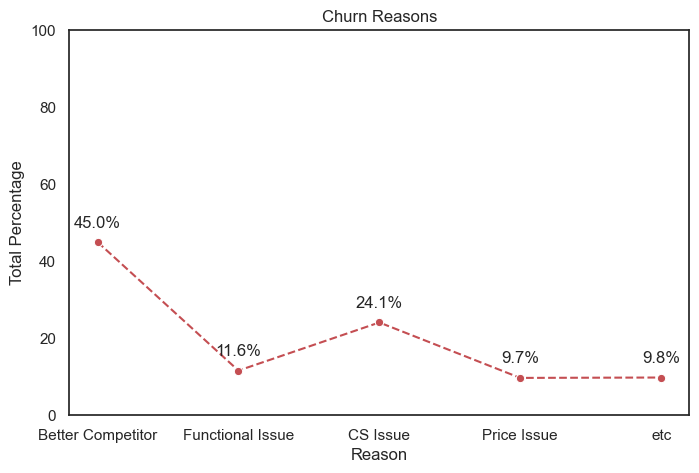

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

df_Churn_Reason = pd.DataFrame({'Reason':['Better Competitor','Functional Issue','CS Issue','Price Issue','etc'],
                                'Total Percentage':[45,11.6,24.1,9.7,9.8]})

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.set_ylim(0,100)

sns.lineplot(data = df_Churn_Reason, x = 'Reason', y = 'Total Percentage',color = 'r', linestyle='--',marker='o', ax=ax)

for x, y, label in zip(df_Churn_Reason['Reason'], df_Churn_Reason['Total Percentage'], df_Churn_Reason['Total Percentage']): # 마지막에 레이블 컬럼이 없기에
    ax.text(x, y+3, f'{label:.1f}%', ha='center', va='bottom')

plt.title('Churn Reasons')

plt.show()

이탈율을 줄이는 데 비용이 가장 적게 들 것 같은 부분 : CS 부분 교육

age                                     AxesSubplot(0.125,0.786098;0.133621x0.0939024)
number_of_dependents                 AxesSubplot(0.285345,0.786098;0.133621x0.0939024)
number_of_referrals                   AxesSubplot(0.44569,0.786098;0.133621x0.0939024)
tenure_in_months                     AxesSubplot(0.606034,0.786098;0.133621x0.0939024)
avg_monthly_long_distance_charges    AxesSubplot(0.766379,0.786098;0.133621x0.0939024)
avg_monthly_gb_download                 AxesSubplot(0.125,0.673415;0.133621x0.0939024)
monthly_charge                       AxesSubplot(0.285345,0.673415;0.133621x0.0939024)
total_charges                         AxesSubplot(0.44569,0.673415;0.133621x0.0939024)
total_refunds                        AxesSubplot(0.606034,0.673415;0.133621x0.0939024)
total_extra_data_charges             AxesSubplot(0.766379,0.673415;0.133621x0.0939024)
total_long_distance_charges             AxesSubplot(0.125,0.560732;0.133621x0.0939024)
total_revenue                        AxesSu

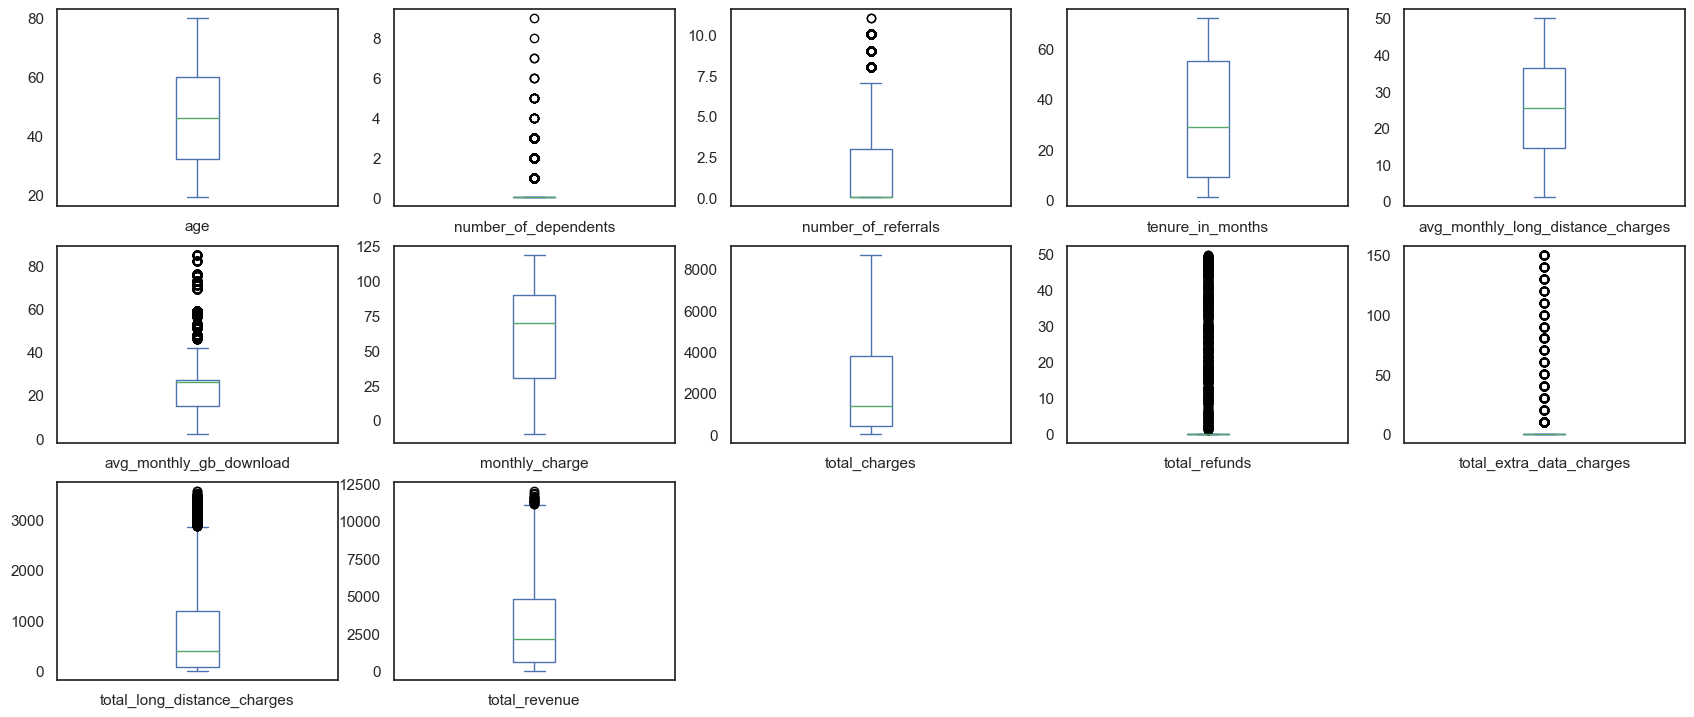

In [27]:
df.plot(kind='box', subplots=True, layout=(7, 5), figsize=(21, 21))
# 수치형(연속형) 컬럼에 대한 이상치 확인?
# 근데 이걸 이상치라고 처내는 게 맞나? - 아니다. 소수지만 없어선 안되는 데이터라

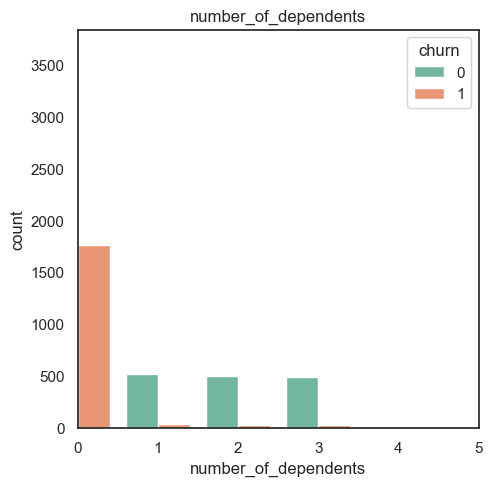

In [67]:
# 난 연속형도 countplot이 필요한 거 같은데?
# 부양자 수는 쓸 수가 없네 (**이렇게 연속형이어도 unique 값이 적으면 countplot 가능)
# 대신 부양자 수와 다른 변수를 조합해볼 가치는 있어보임.

object_col20 = ['number_of_dependents']
plt.figure(figsize=(30,30))

for i, col in enumerate(object_col20): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")
    plt.xlim(0,5)

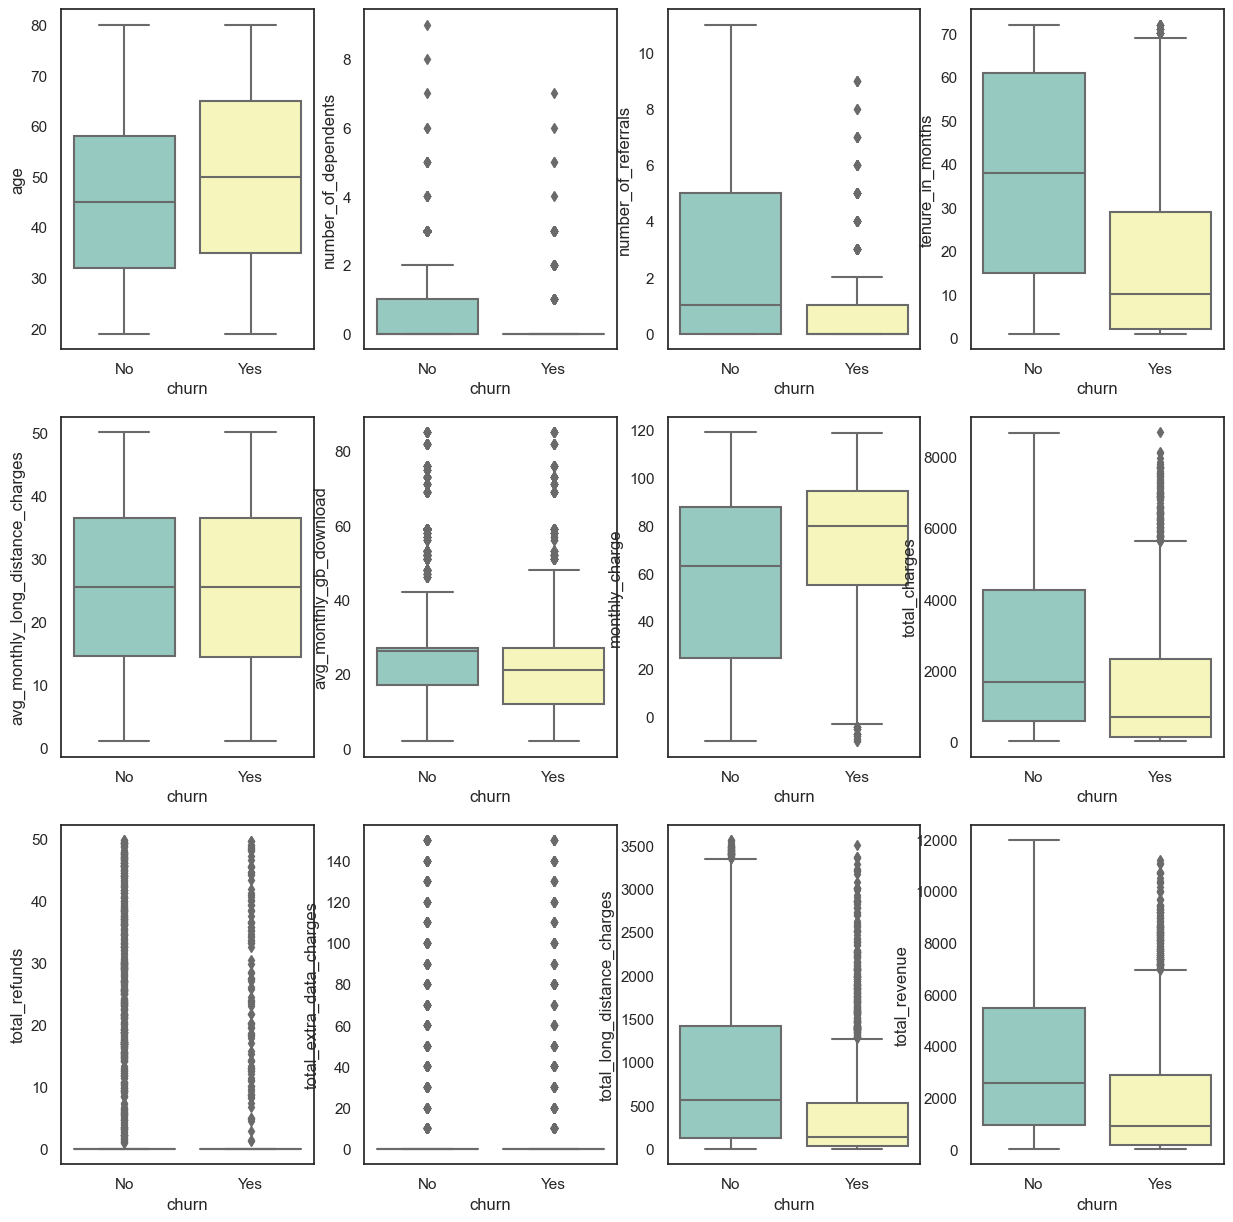

In [22]:
number_col = ['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
              'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges',
              'total_long_distance_charges', 'total_revenue']

fig, ax = plt.subplots(3,4, figsize = (15,15))
for i, subplot in zip(number_col, ax.flatten()):
    sns.boxplot(x = 'churn', y = i , data = df, ax = subplot, palette = 'Set3')

- **number of dependents**: 대부분의 고객은 부양가족이 없습니다.

- **monthly charge**: 이탈 고객의 월간 요금 중앙값이 충성고객의 월간 요금 중앙값보다 높다는 것을 알 수 있습니다. 요금이 너무 높으면 고객이 이탈할 가능성이 더 높다고 생각할 수 있습니다.
    - feedback: 높은 요금을 쓰는 메리트가 없어, 높은 요금을 쓰는 사람의 탈퇴비율 up


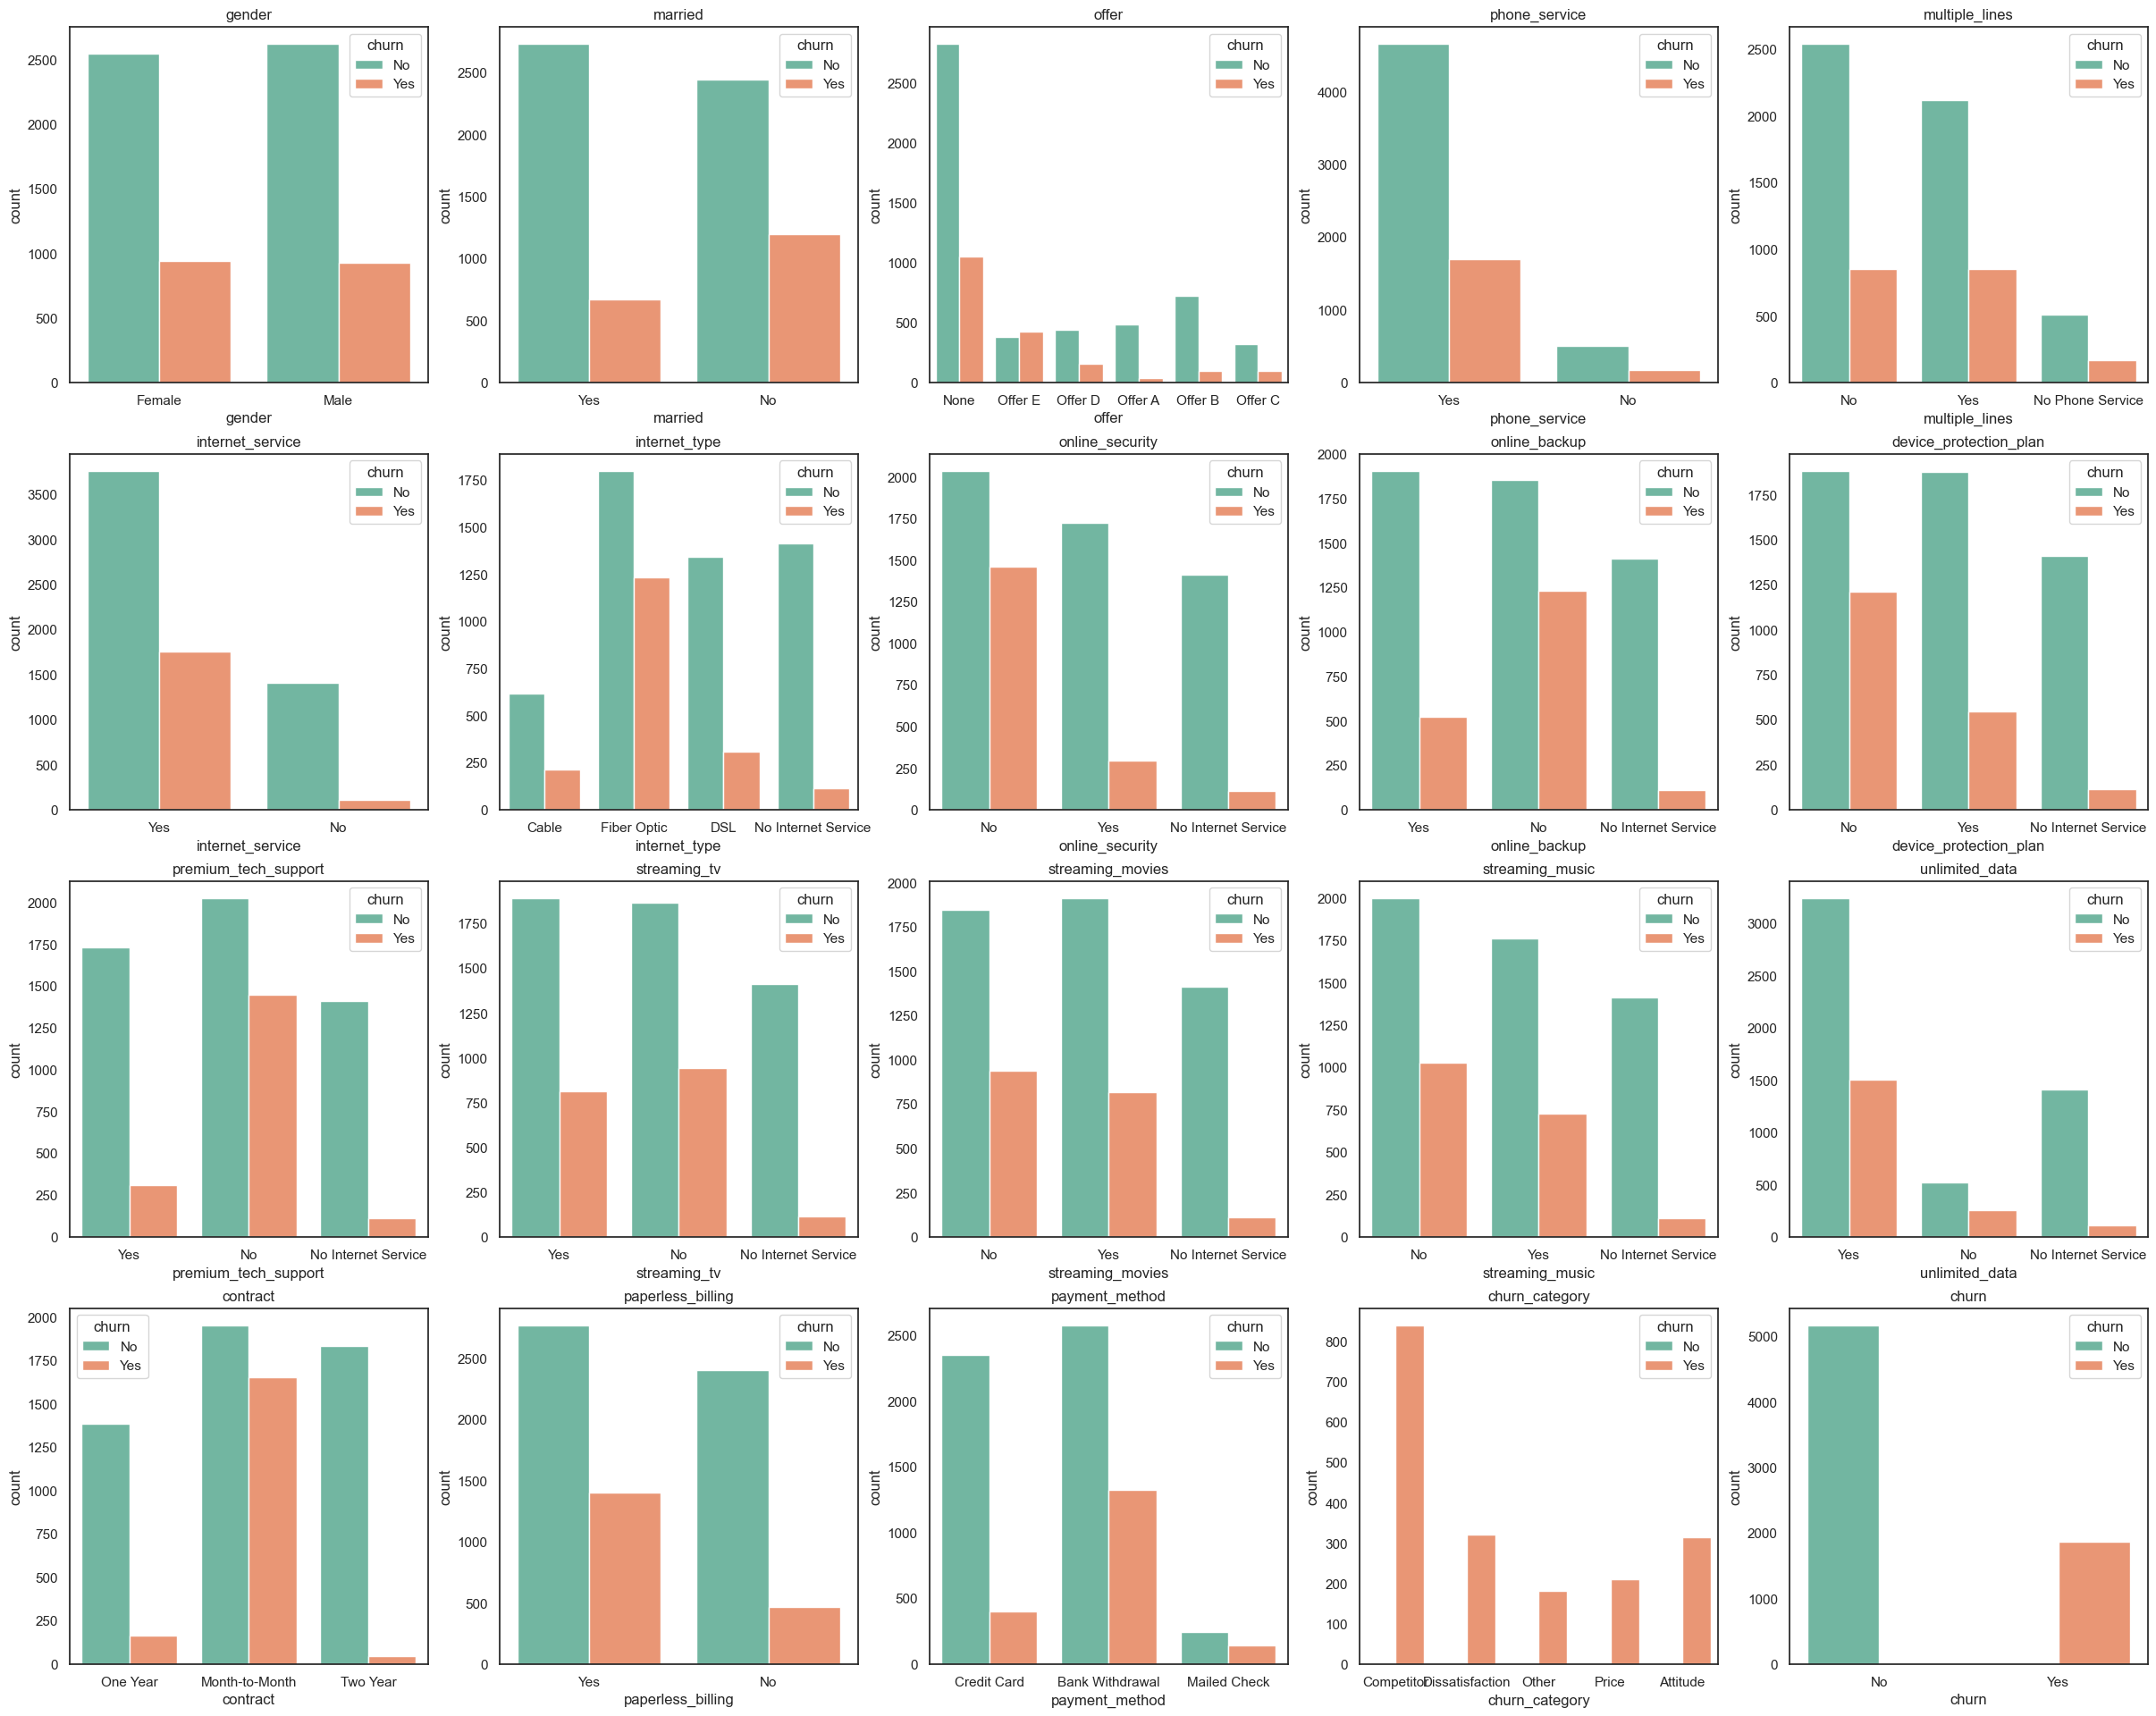

In [16]:
# 각 컬럼들을 churn의 여부별로 시각화(Countplot)

object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
              'churn_category', 'churn']

plt.figure(figsize=(30,30))

for i, col in enumerate(object_col): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")

- **offer**: 대부분의 고객은 마케팅 제안을 수락하지 않았습니다. 기업은 낮은 마케팅율을 개선하기를 바랄 수 있습니다. 마케팅 제안 E를 구독한 후 높은 고객 이탈률을 관찰했습니다.
+++

- tenure_in_months
+++

- paperless_bilimng
+++

- payment_method
+++

- online_security
+++




- **multiple lines**: multiple lines는 충성고객과 이탈 고객이 균등하게 분배되어 있으므로 고객 이탈 여부에 영향을 미치지 않을 것이라고 생각할 수 있습니다.


- **internet service**: 인터넷 서비스에 가입하면 이탈율이 높아집니다.
    - 결합해서 쓰는 경우 이탈율 높아짐 34.5%
    - 인터넷 서비스 유저 이탈율 26.4%
    - 폰서비스 유저 이탈율 8.4%
+++


- **internet type**: Fiber > DSL > Cable. 다양한 인터넷 연결 유형 중 Fiber Optic이 가장 널리 사용됩니다. Cable 및 DSL에 비해 가격이 비싸더라도 다운로드 및 업로드 속도가 가장 빠르기 때문입니다.
+++
    - feedback 요금이 비싼 데 비하여, 통신사쪽 메리트가 없음(그래서 이탈율 up).
    - 지훈: 의사결정트리 (fiber == 1, other == 0).

- **online security, online backup, device protection plan**: 인터넷 부가서비스. 이탈 고객은 이 기능을 구매(선택)할 가능성이 거의 없습니다.

- **premium tech support**: 많은 이탈 고객이 premium tech support를 받지 않았습니다. 기술적 문제가 이탈 결정에 영향을 미칠 수도 있다는 것을 알 수 있습니다.
+++

- **streaming tv, movies, music**: streaming tv, movies, music은 충성고객과 이탈고객의 큰 차이가 없이 균등해 보이므로 고객 이탈 여부에 영향을 미치지 않을 것이라고 생각할 수 있습니다.


- **unlimited data**: 많은 고객에게 무제한 데이터가 인기가 있습니다.


- **contract**: 월 단위로 지불하는 사용자는 이탈할 가능성이 높습니다. 대부분의 충성 고객은 1, 2년 계약입니다.
+++


In [ ]:
# 시각화를 통해서 이런 저런 피처들이 이탈과 중요한 관계가 있다고 봤어
# 그래서 그 피처들로만 머신러닝 돌려봤는데 점수는~~~고
# 양향력 검사도 해보고(이거 로직 확인해봐야함)
# 진짜 중요한 피처들은 ~~~거였고, 이걸로만 돌렸을 때 이탈고객들을 이정도 점수로 예측할 수 있더라
# 이탈 예측 고객 리스트들을 뽑아서 _ 이탈 고객들과의 공통점을 찾아보고
# 이를 해결하는 솔루션은 ~~~인 것 같다~(결론)

In [ ]:
# ㅈㄴ 안보여서 따로따로 봐줘야 할 듯.

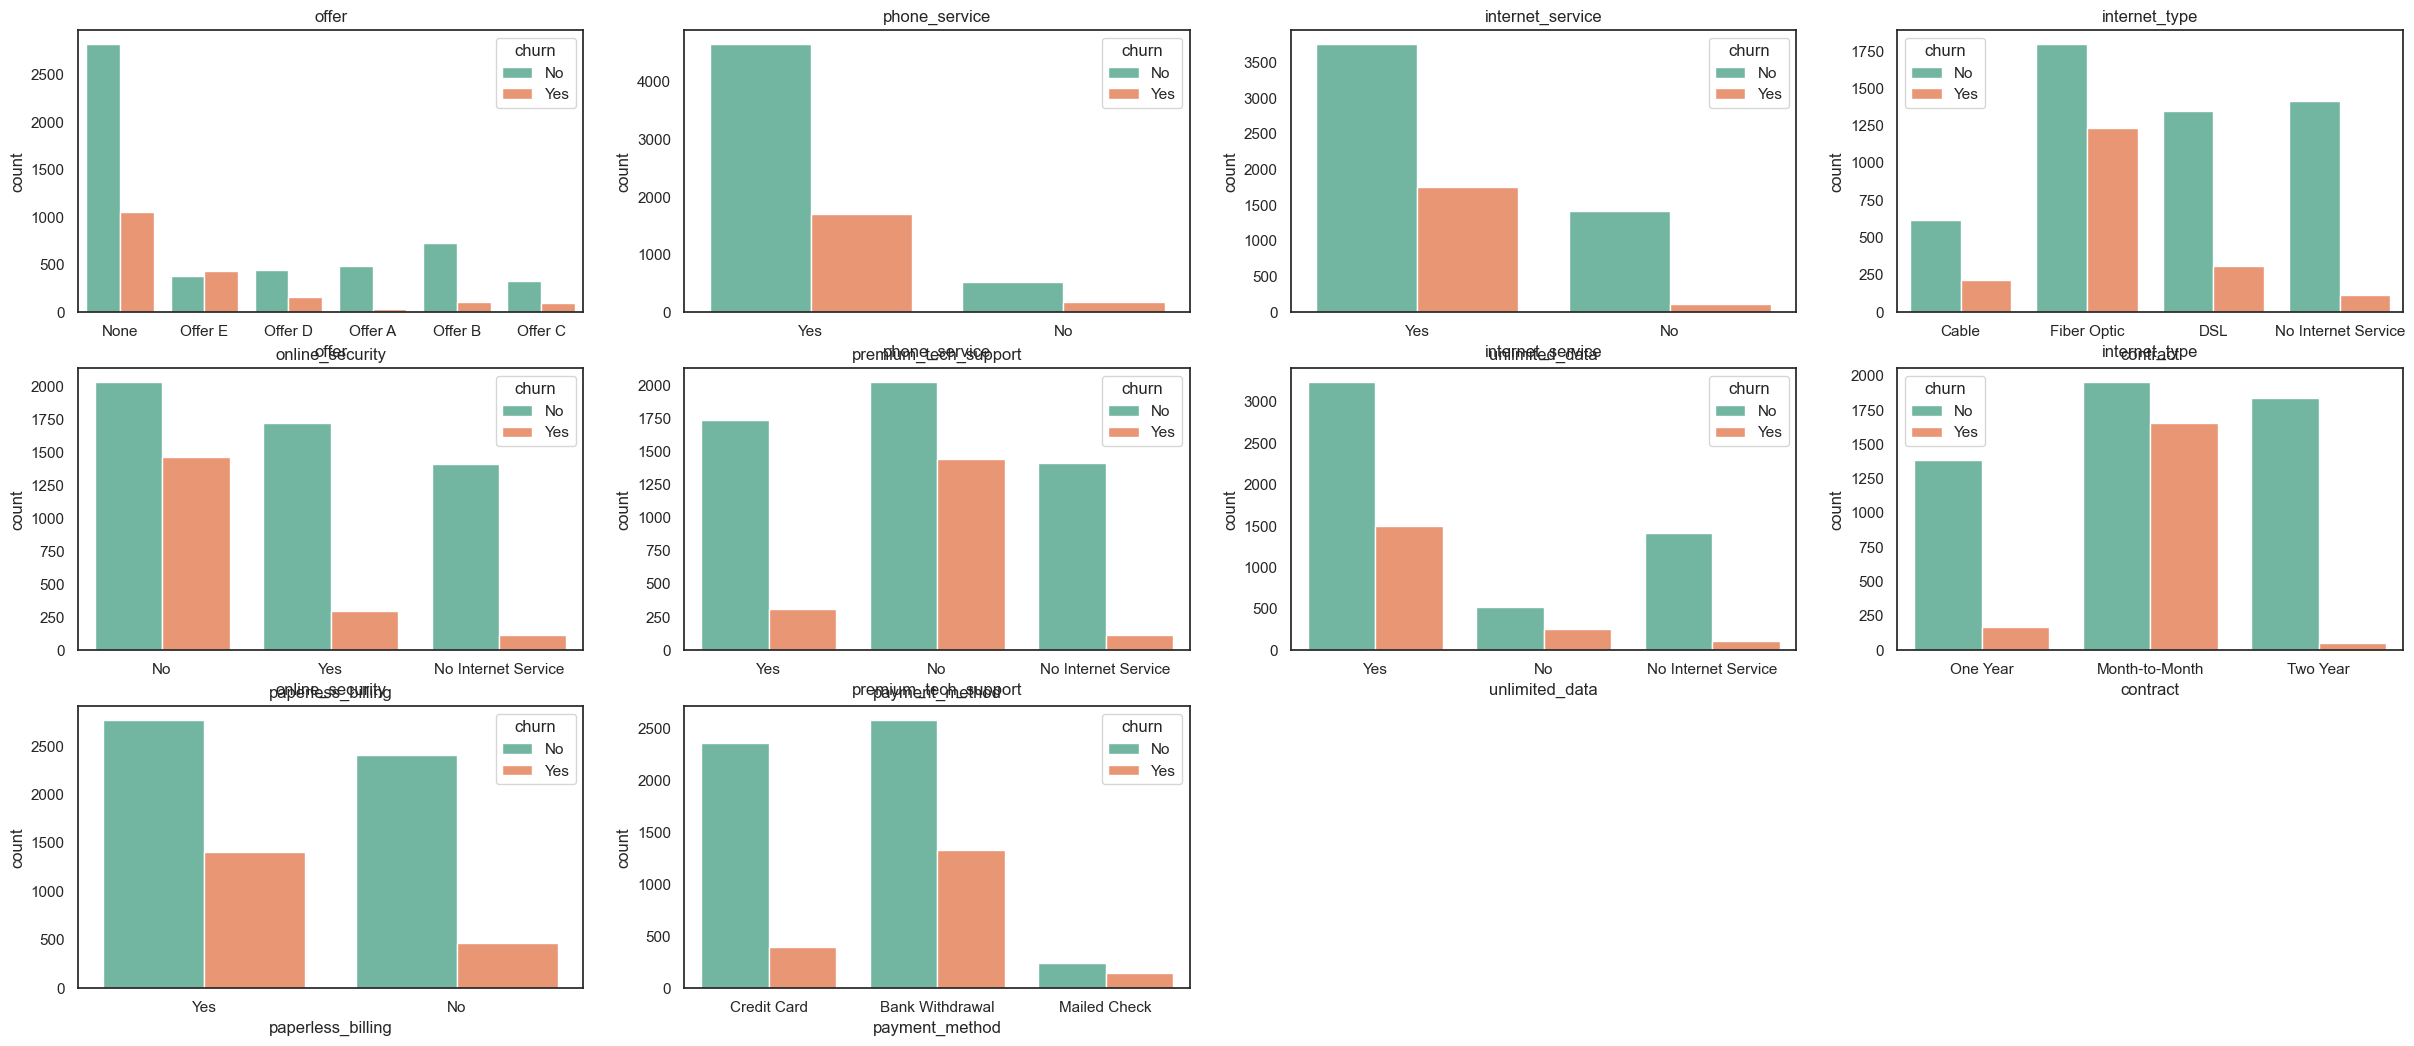

In [25]:
# 각 컬럼들을 churn의 여부별로 시각화(Countplot)

object_col = ['offer', 'phone_service', 'internet_service', 'internet_type',
              'online_security', 'premium_tech_support',
            'unlimited_data', 'contract', 'paperless_billing', 'payment_method']

plt.figure(figsize=(30,30))

for i, col in enumerate(object_col): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(7, 4, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")

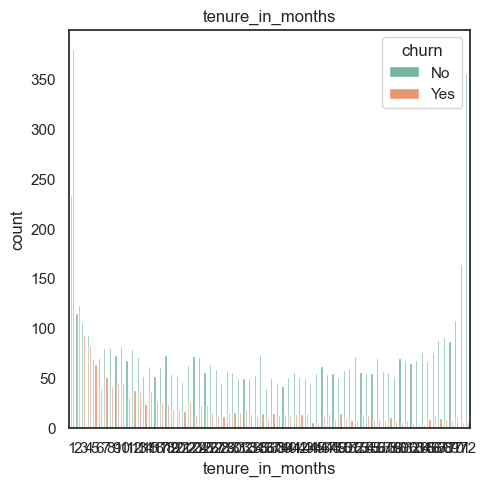

In [27]:
# 각 컬럼들을 churn의 여부별로 시각화(Countplot)

object_col = ['tenure_in_months']

# 이거 전처리 어케함? x값 범위들을 묶어줘서 (6개월마다로)
# + 1년마다로

plt.figure(figsize=(30,30))

for i, col in enumerate(object_col): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")

In [46]:
df.columns

Index(['customer_id', 'gender', 'age', 'married', 'number_of_dependents',
       'number_of_referrals', 'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn_category', 'churn_reason',
       'churn'],
      dtype='object')

In [28]:
#범주가 두 개가 아닌 3개의 경우를 그리기 위해 가입기간에 따라 함수로 범주 구분
# 함수로했어서 형처럼 3개까지가 최대로 그려주더라
def classify_tenure_in_months(tenure):
    if tenure >= 0 and tenure <= 12:
        return 0
    elif tenure > 12 and tenure <= 24 :
        return 1
    elif tenure > 24 and tenure <= 36:
        return 2
    elif tenure > 36 and tenure <= 48:
        return 3
    return 4
df_new['tenure_class'] = df_new['tenure_in_months'].apply(classify_tenure_in_months)
df_new['tenure_class'].value_counts().sort_index()

0    2186
1    1024
2     832
3     762
4    2239
Name: tenure_class, dtype: int64

In [29]:
# 인사이트 도출 시 필요한 그래프를 그리기 위한 함수 생성
def graph_feature_churn_rate_by_class(col, classes, classes_desc, figsize=(6, 6), print_info=False):
    churned = []
    stayed = []
    for cls in classes:
        counts = df_new[df_new[col]==cls]["churn"].value_counts()
        churned.append(counts[1])
        stayed.append(counts[0])
    percent_churned = [f"{round(churned[i] / (churned[i] + stayed[i]) * 100, 0)}% churned" for i in range(len(classes))]
    plt.figure(figsize=figsize)
    bar1 = plt.bar(classes_desc, churned, color='dodgerblue')
    bar2 = plt.bar(classes_desc, stayed, bottom=churned, color='lightblue')
    plt.bar_label(bar2, percent_churned)
    plt.ylabel("Number of customers")
    plt.legend(["Churned", "Stayed"])
    plt.show()
    if print_info:
        print(churned, stayed, percent_churned)

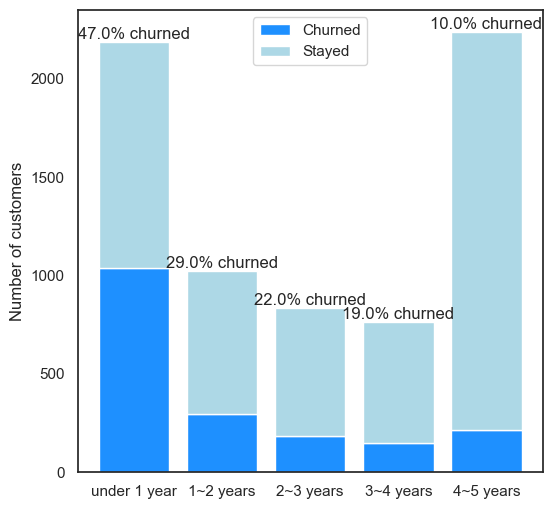

In [30]:
# 가입 기간에 따라 이탈률 시각화
graph_feature_churn_rate_by_class('tenure_class', [0,1,2,3,4],['under 1 year','1~2 years','2~3 years', '3~4 years', '4~5 years'])

- 여기서 인사이트를 더 뽑아놓아야 한다. 그래서 이탈하는 사람들은 왜 이탈하는 거 같은데?
- 이탈하는 사람들의 특징이 뭔데? 이탈하지 않는 사람들에 비해서

- 컬럼들을 이용해서 더 세분화된 솔루션을

아 하나씩 봐야할 거 같은데?

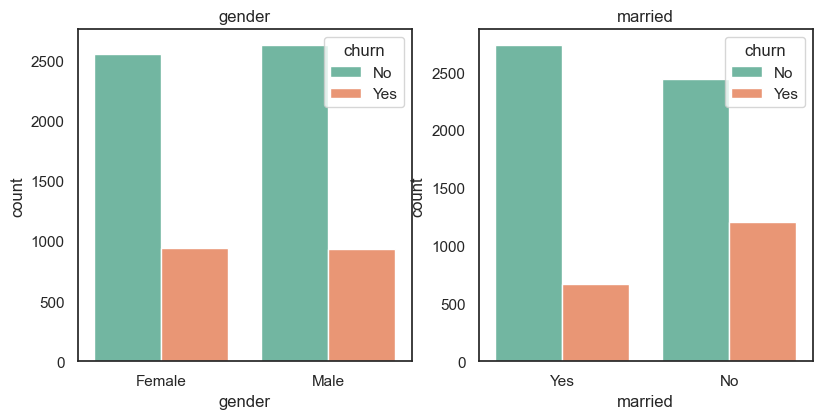

In [31]:
object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
              'churn_category', 'churn']

# 카테고리별로
object_col2 = ['gender', 'married'] # 성별과 결혼

plt.figure(figsize=(25,25))

for i, col in enumerate(object_col2): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")

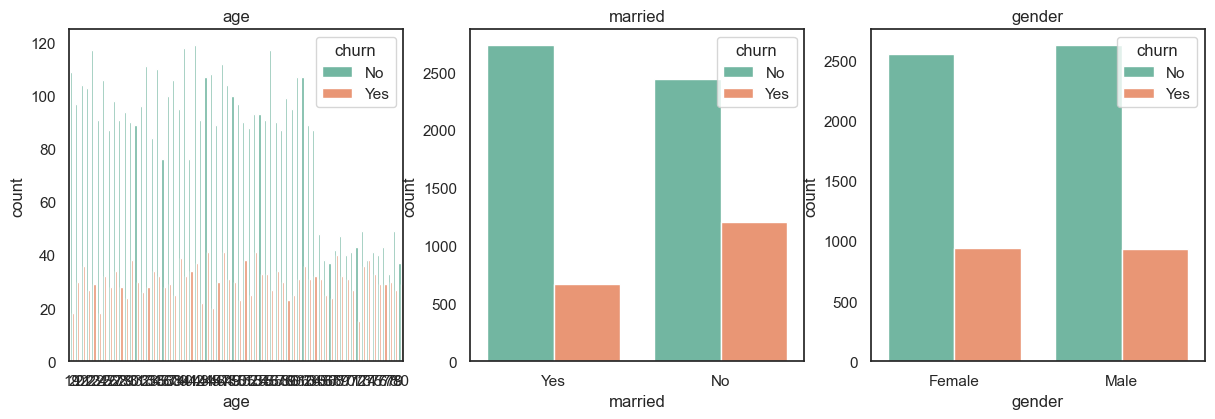

In [32]:
object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
              'churn_category', 'churn']

# 카테고리별로
object_col2 = ['age', 'married', 'gender'] # 나이도 연령대를 나눠야 할 것 같고,

plt.figure(figsize=(25,25))

for i, col in enumerate(object_col2): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")

성별은 차이가 거의 없고, 결혼여부는 결혼을 안한 사람들이 더 이탈.

** 근데 더 깊게 인사이트 찾으려면 gender와 다른 컬럼을 섞어봐야 하는데 그게 안되는 중.

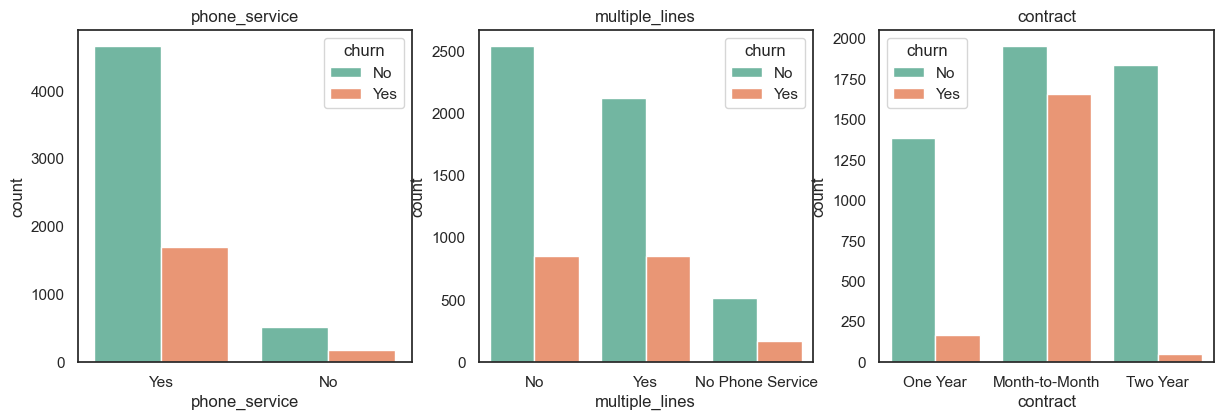

In [33]:
object_col3 = ['phone_service', 'multiple_lines','contract'] # 폰 서비스 관련
# unlimited data가 폰서비스 관련임? 인터넷이 아니라?

plt.figure(figsize=(25,25))

for i, col in enumerate(object_col3): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")

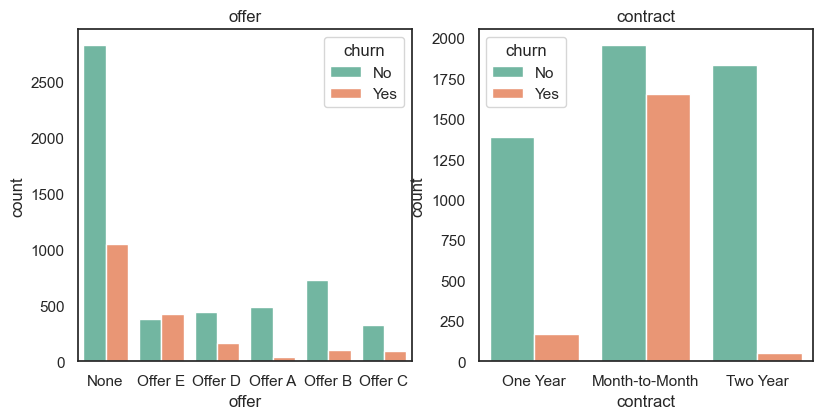

In [34]:
object_col4 = ['offer','contract'] # 마케팅 받은 방식

plt.figure(figsize=(25,25))

for i, col in enumerate(object_col4): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")

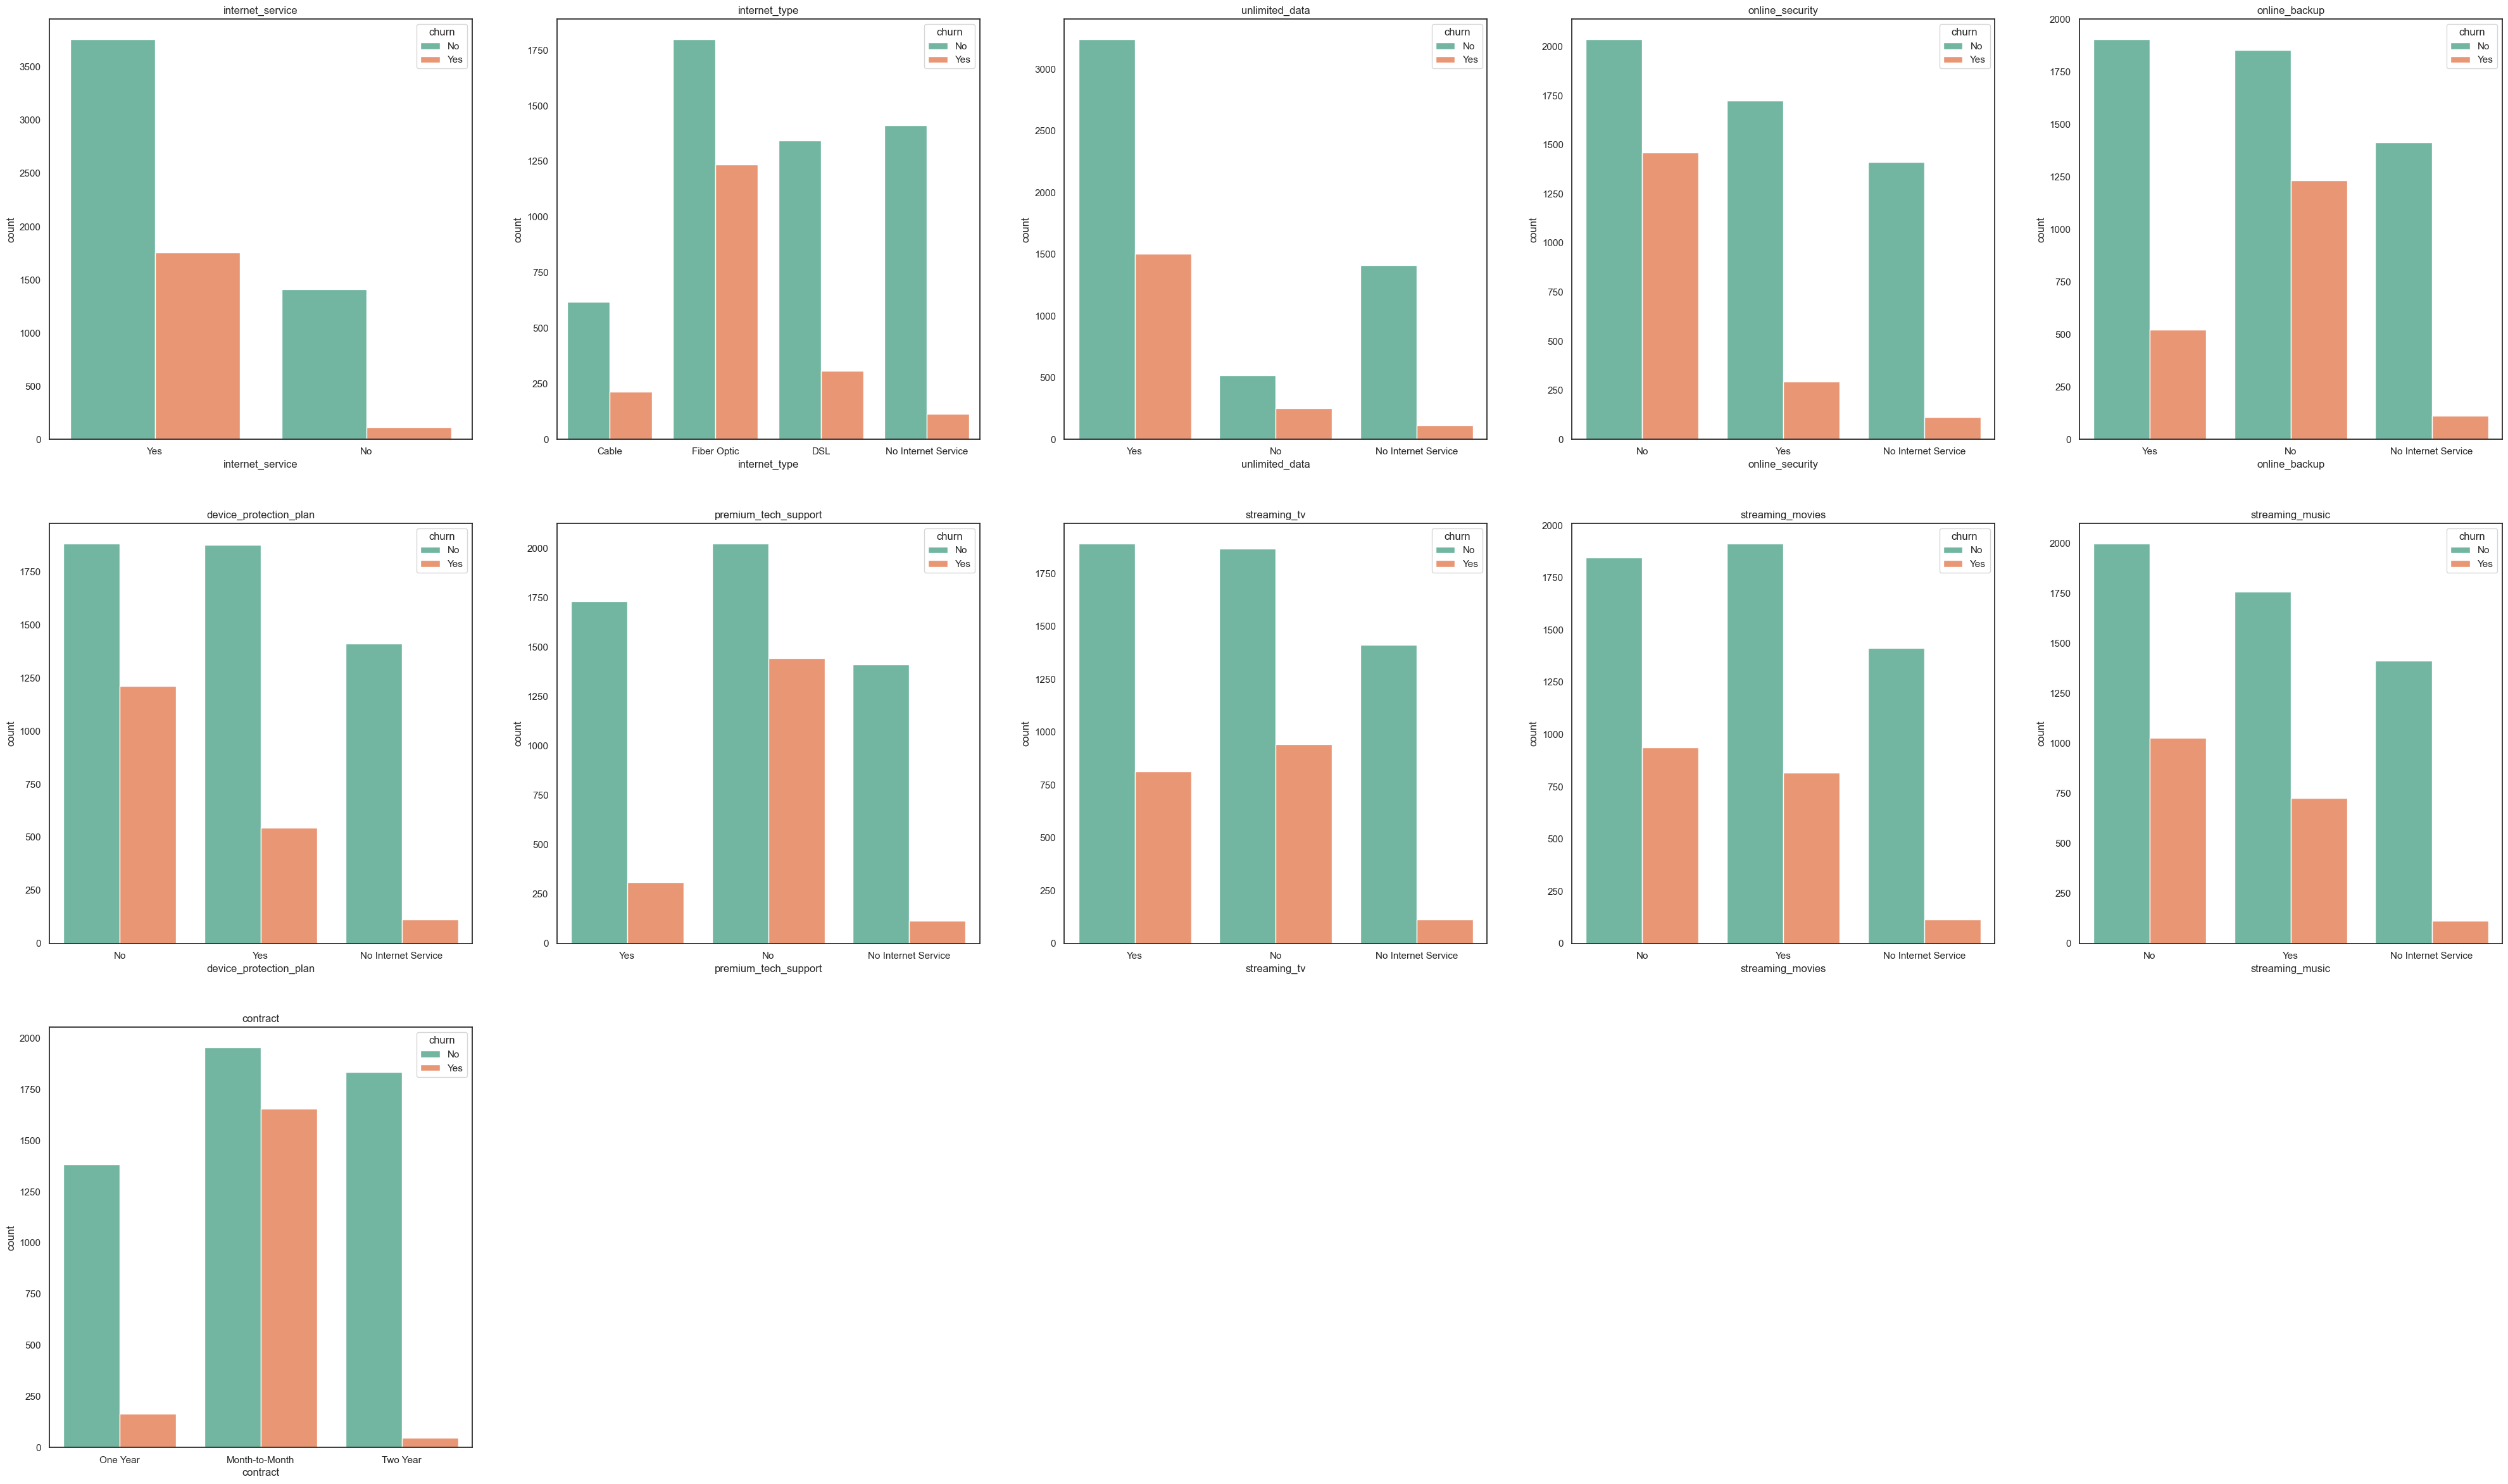

In [35]:
# 인터넷 서비스인데, 더 나눠서 봐야할 듯?

object_col5 = ['internet_service', 'internet_type','unlimited_data','online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music','contract']

plt.figure(figsize=(50,50))

for i, col in enumerate(object_col5): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기

    ax.set_title(f"{col}")

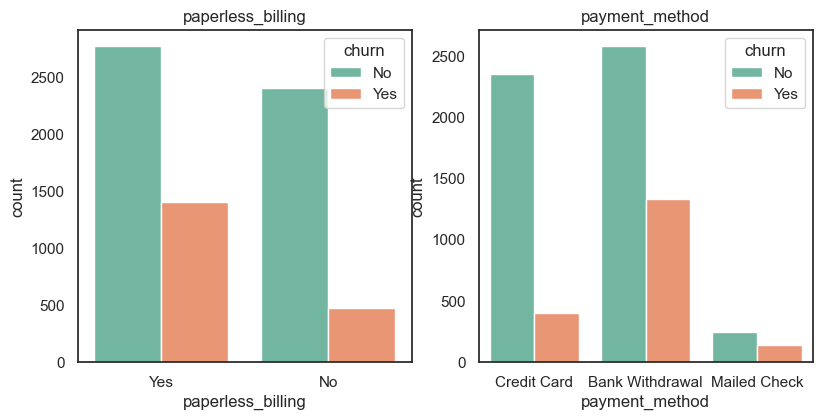

In [36]:
# 지출 방식

object_col6 = ['paperless_billing', 'payment_method']

plt.figure(figsize=(25,25))

for i, col in enumerate(object_col6): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")

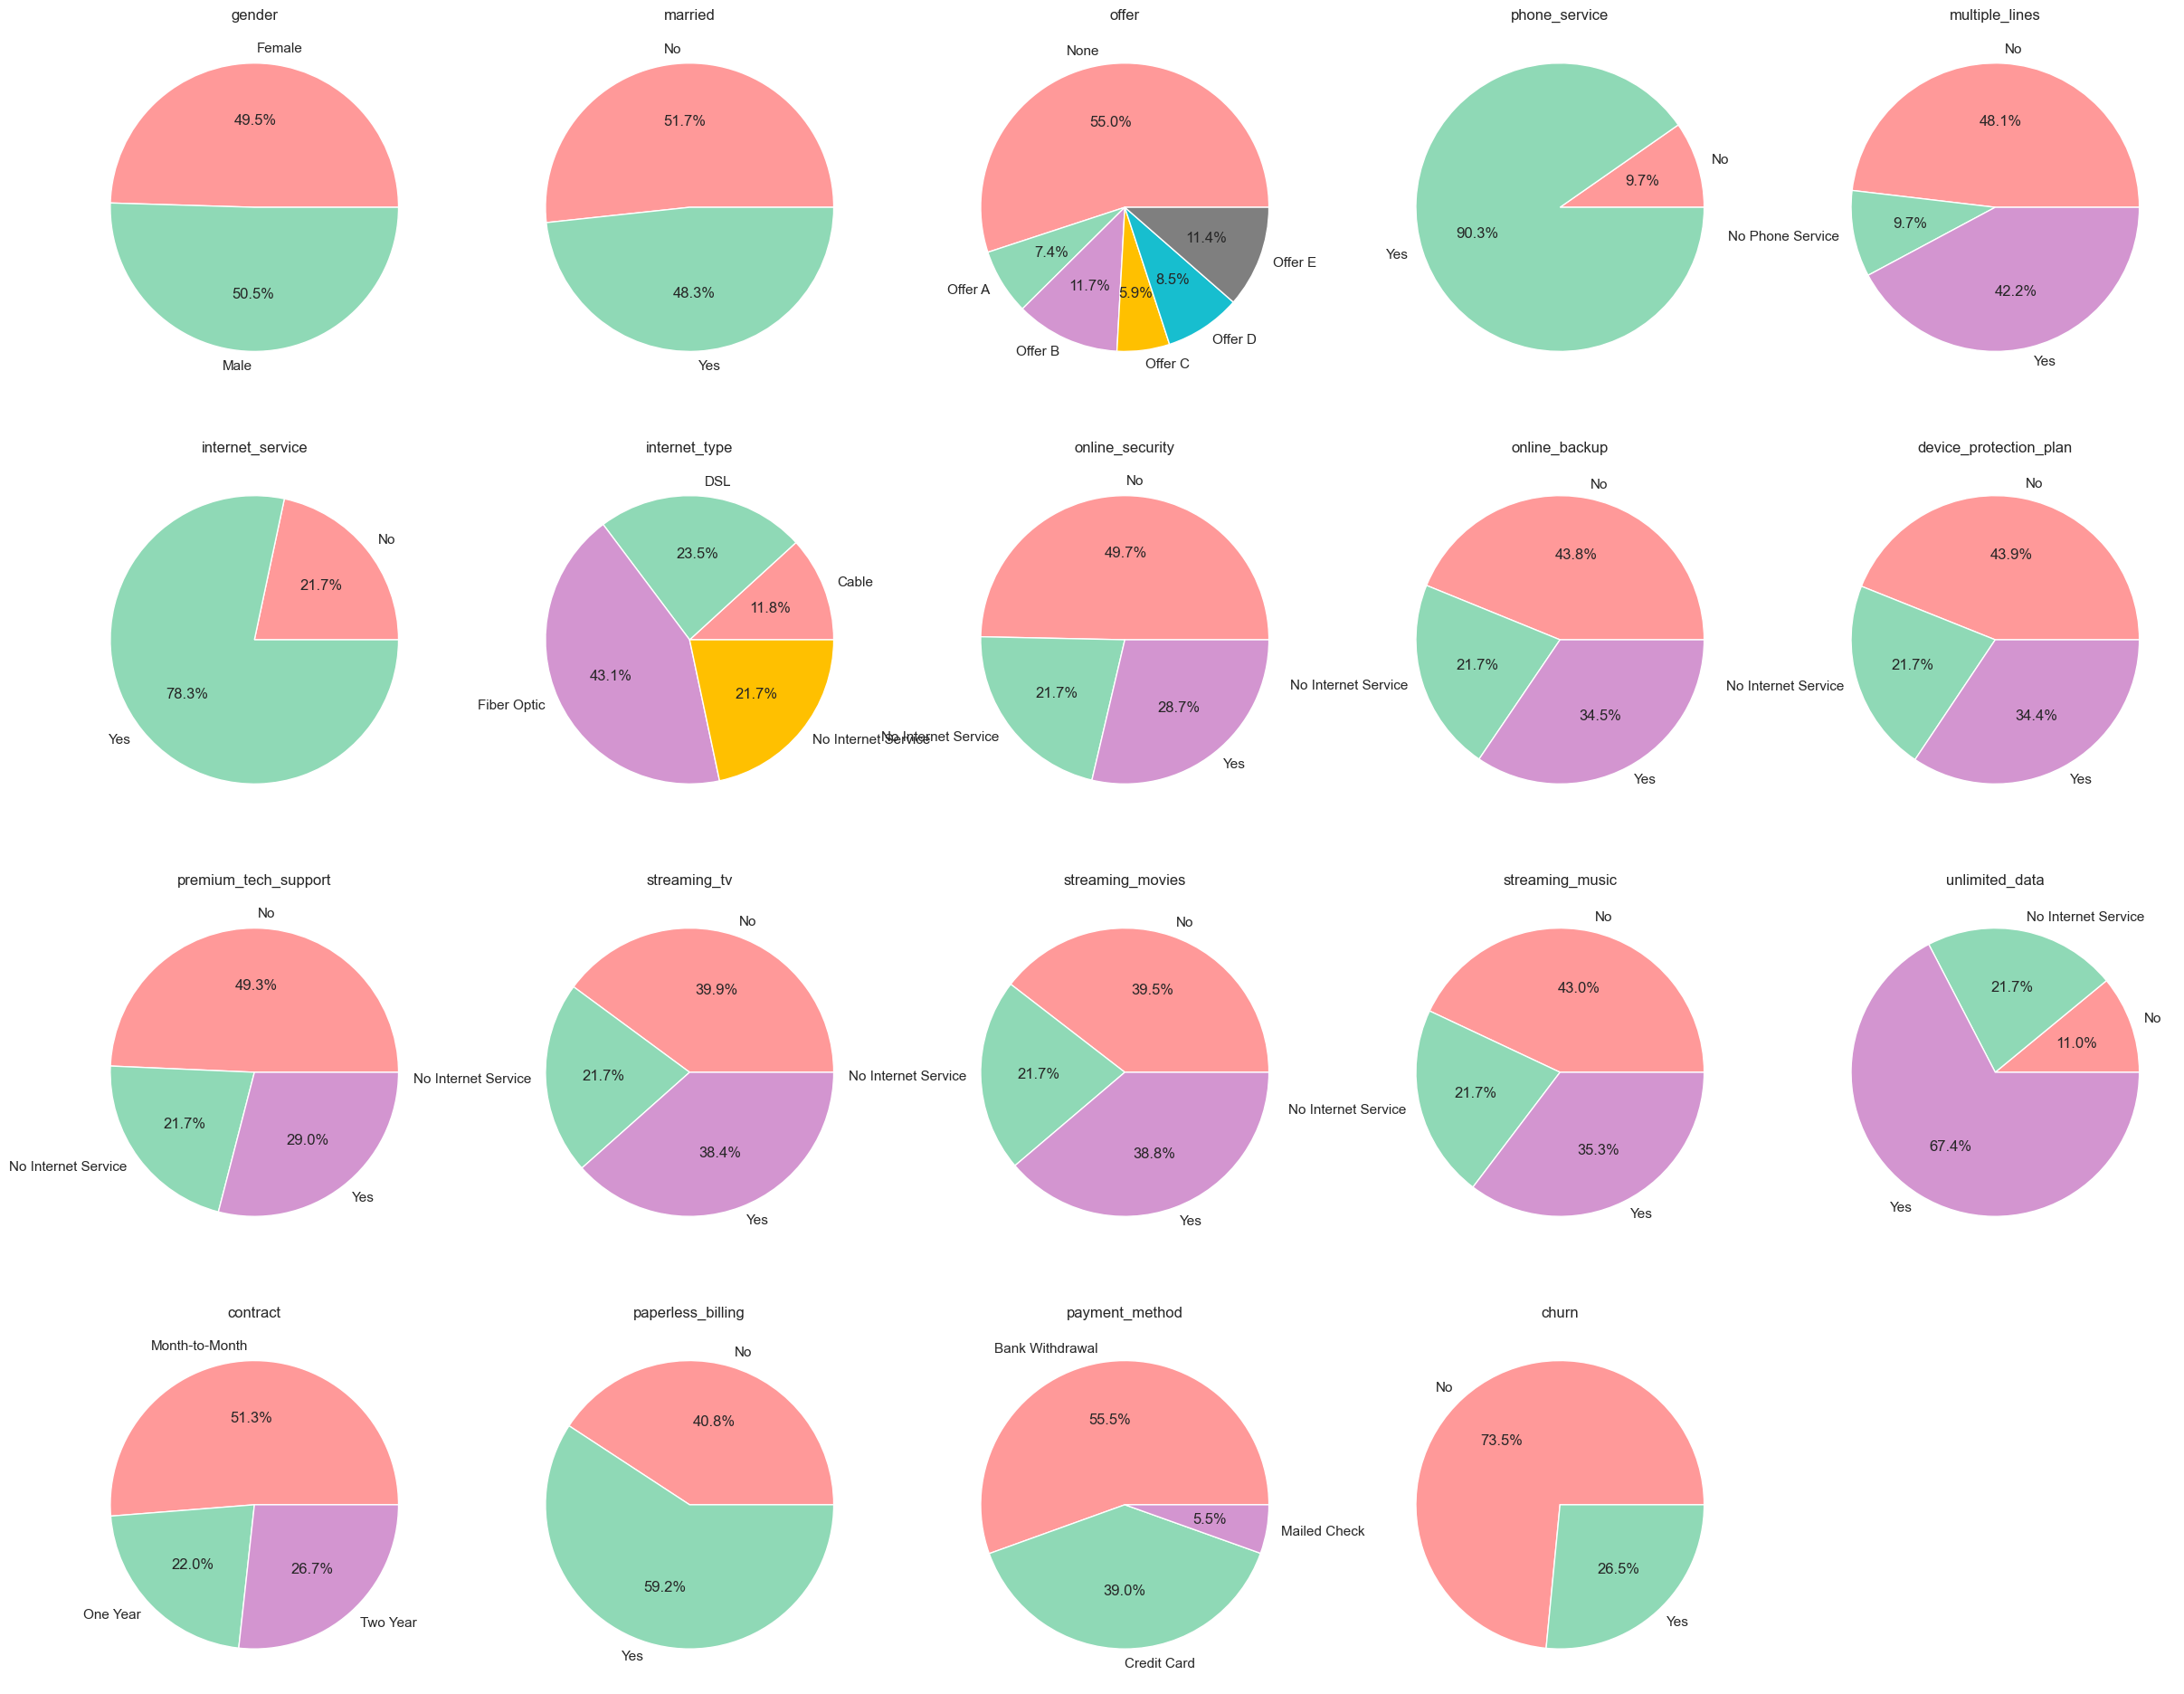

In [37]:
# 파이차트는 굳이 왜쓰나싶음. 쓸 일이 있나?
# 각 지분을 크고 깔끔하게 보기 위해서는 쓸 듯(비율) - 비율을 보는 게 아니면 무의미.

object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method', 'churn']
#_ = df[object_col]
colors = ['#ff9999', '#8fd9b6', '#d395d0', '#ffc000', '#17becf', '#7f7f7f']

fig = plt.figure(figsize = (30, 30))
i = 1
for a in df[object_col].columns:
    plt.subplot(5, 5, i)
    ax = df.groupby([a]).size().plot(kind = 'pie', autopct = '%.1f%%', colors = colors)
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(a), loc='center')
    i += 1

In [49]:
df.columns

Index(['gender', 'age', 'married', 'number_of_dependents',
       'number_of_referrals', 'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn'],
      dtype='object')

# 인사이트 1. 이탈 고객으로 인한 수입 감소

In [60]:
df.groupby('churn')['monthly_charge'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,5174.0,60.073618,32.056245,-10.0,24.8,63.2,87.5,118.75
1,1869.0,73.347592,26.373764,-10.0,55.3,79.5,94.2,118.35


- 이탈한 고객들 1명당 평균 73.3 달러를 요금으로 지불했었고, 중앙값 기준 79.5 달러를 지불했었음.

즉, 고객 1명당 수입 감소가 79.5 달러

기존 고객들은 평균 60달러, 중앙값 63.2달러씩 요금을 지불하는데,

- 해당 이동통신사가 이탈 고객들로 인한 수입 감소를 기존 고객에게서 채우려면 약 16.3$씩 더 추가 요금을 받아내야 함.

하지만, 이는 불가능에 가까움.

- 따라서, 이탈을 방지하는 것이 비용도 적게 들고, 현실적으로 수입 감소를 줄일 수 있음.

## 인사이트2. 신규 가입자의 이탈률

In [62]:
# 신규 가입자의 이탈률을 알아보기 위함.
df_newjoin = df[df['tenure_in_months'] <= 3]

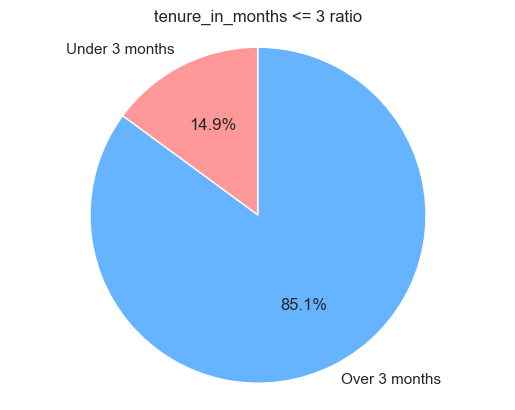

In [65]:

# 데이터셋 생성
labels = ['Under 3 months', 'Over 3 months']
sizes = [len(df_newjoin), len(df) - len(df_newjoin)]
colors = ['#ff9999','#66b3ff']

# 파이차트 그리기
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# 정원 표시 (원이 원에 맞게 보이도록)
plt.axis('equal')

# 제목 추가
plt.title('tenure_in_months <= 3 ratio')

# 그래프 출력
plt.show()

In [ ]:
# 데이터 셋에서 3개월 이하의 신규 가입자는 약 14.9% 비율.

In [67]:
df_newjoin.groupby('churn').describe()

gender                                                 age             \
       count      mean       std  min  25%  50%  75%  max  count       mean   
churn                                                                         
0      454.0  0.535242  0.499307  0.0  0.0  1.0  1.0  1.0  454.0  42.870044   
1      597.0  0.490787  0.500334  0.0  0.0  0.0  1.0  1.0  597.0  47.906198   

       ... total_long_distance_charges         total_revenue              \
       ...                         75%     max         count        mean   
churn  ...                                                                 
0      ...                      51.495  148.89         454.0  119.558921   
1      ...                      45.490  149.28         597.0  132.028710   

                                                         
             std    min    25%      50%     75%     max  
churn                                                    
0      89.466565  21.36  56.97   91.095  166.24  456.10  
1      90.299706  21.61  76.74  103.630  166.44  458.55  

[2 rows x 232 columns]

In [69]:
597/1051

0.5680304471931494

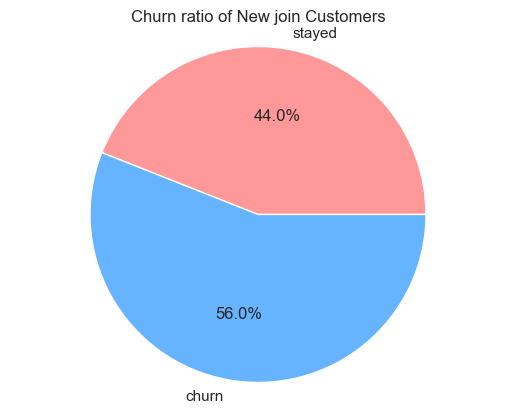

In [72]:
sizes=[44,56]
labels=['stayed','churn']
colors = ['#ff9999', '#66b3ff']

plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%')
plt.title('Churn ratio of New join Customers')
plt.axis('equal')

plt.show()

- 신규 가입자 중 56%가 3개월 안에 이탈함.

## 이탈 이유 카테고리화

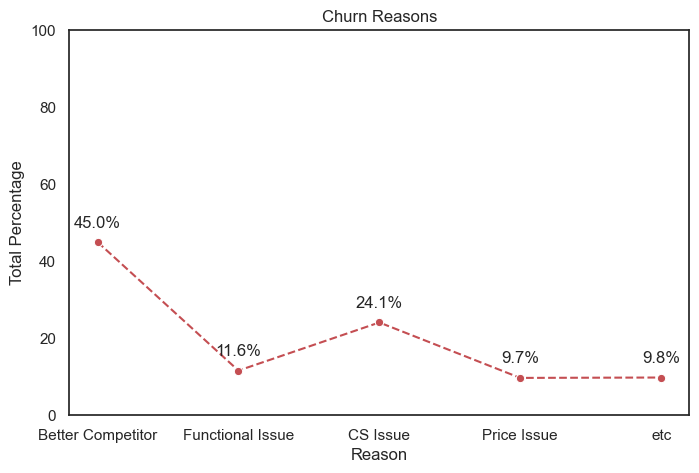

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

df_Churn_Reason = pd.DataFrame({'Reason':['Better Competitor','Functional Issue','CS Issue','Price Issue','etc'],
                                'Total Percentage':[45,11.6,24.1,9.7,9.8]})

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.set_ylim(0,100)

sns.lineplot(data = df_Churn_Reason, x = 'Reason', y = 'Total Percentage',color = 'r', linestyle='--',marker='o', ax=ax)

for x, y, label in zip(df_Churn_Reason['Reason'], df_Churn_Reason['Total Percentage'], df_Churn_Reason['Total Percentage']): # 마지막에 레이블 컬럼이 없기에
    ax.text(x, y+3, f'{label:.1f}%', ha='center', va='bottom')

plt.title('Churn Reasons')

plt.show()

- 가장 빠르고 적은 비용으로 해결할 수 있는 방법이 CS 개선.

## 인사이트3. 서비스 가입 종류별 이탈률

In [ ]:
- 인터넷 서비스만, 폰 서비스만, 둘다 사용하는 고객 3가지로

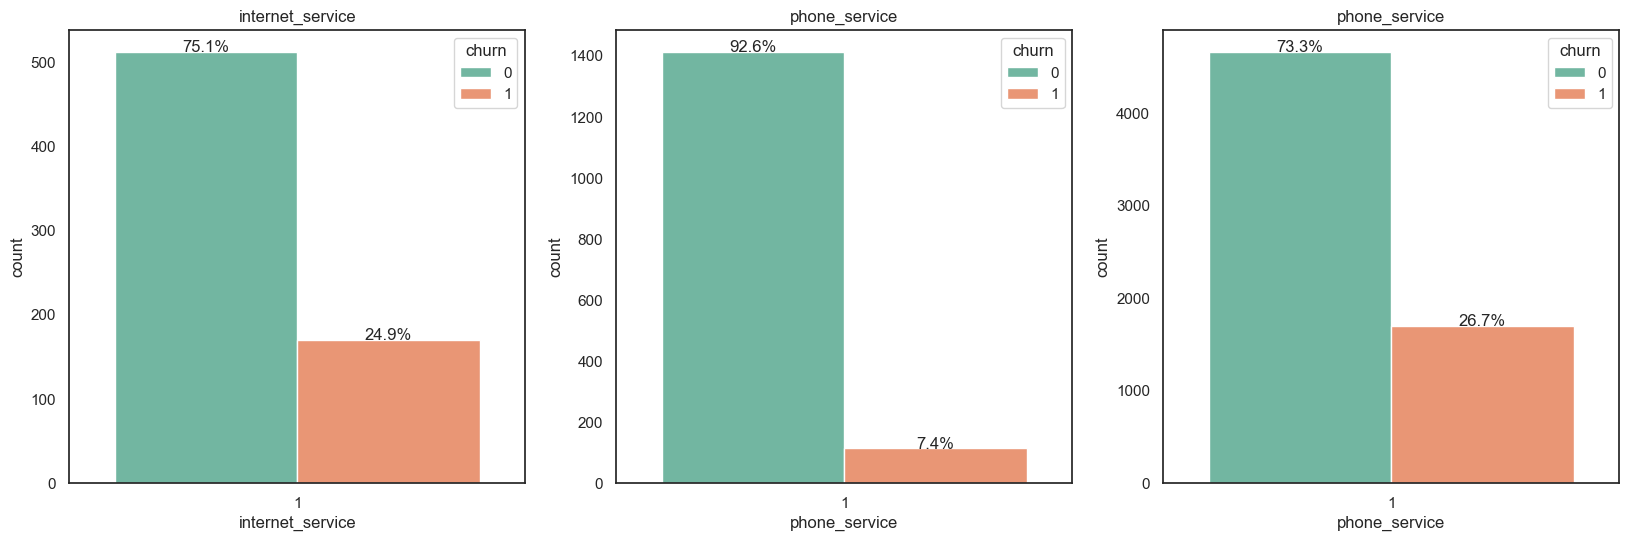

In [100]:
object_col30 = ['internet_service', 'phone_service', 'phone_service']

plt.figure(figsize=(20, 20))

for i, col in enumerate(object_col30):
    if col == 'internet_service':
        filtered_df = df[df[col] == 1]
        # 이런식으로도 특정 컬럼 값만 나오게 할 수 있네?
        filtered_df = df[df['phone_service'] == 0]
    elif i == 2:
        filtered_df = df[df['internet_service']==1]
        filtered_df = df[df['phone_service']==1]
    elif col == 'phone_service':
        filtered_df = df[df[col] == 1]
        filtered_df = df[df['internet_service'] == 0]
    else:
        pass
    
    ax = plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='churn', data=filtered_df, palette='Set2')
    ax.set_title(f"{col}")
    
    total = len(filtered_df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, f'{height/total*100:.1f}%', ha="center")

plt.show()


In [ ]:
# 특정 조건 하에 특정 컬럼 값 보는 법 loc

In [164]:
df.loc[df['internet_service']==1,['churn_reason']]
# 인터넷 서비스를 사용하는 고객중에서는 이탈 이유가 없나보네
# 이탈 고객이 아니라 그런거같은데

,churn_reason


- 인터넷 서비스를 사용하는 고객 중 이탈률 31.8%
- 폰 서비스를 사용하는 고객 중 이탈률 7.4%
- 폰, 인터넷 서비스 둘다 사용하는 고객 중 이탈률 26.7%

- 따라서, 인터넷 서비스에서 고객들이 많이 이탈하는 경향이 있음 알게됨.

In [90]:
df.groupby('phone_service')['churn'].describe()

,count,mean,std,min,25%,50%,75%,max
phone_service,,,,,,,,
0,682.0,0.249267,0.432906,0.0,0.0,0.0,0.0,1.0
1,6361.0,0.267096,0.442478,0.0,0.0,0.0,1.0,1.0


In [91]:
df.groupby('internet_service')['churn'].describe()

,count,mean,std,min,25%,50%,75%,max
internet_service,,,,,,,,
0,1526.0,0.074050,0.261938,0.0,0.0,0.0,0.0,1.0
1,5517.0,0.318289,0.465855,0.0,0.0,0.0,1.0,1.0


## 인사이트4. 가입 유지 기간별, 약정별 고객 이탈률*

In [102]:
#범주가 두 개가 아닌 3개의 경우를 그리기 위해 가입기간에 따라 함수로 범주 구분
# 함수로했어서 형처럼 3개까지가 최대로 그려주더라
def classify_tenure_in_months(tenure):
    if tenure >= 0 and tenure <= 12:
        return 0
    elif tenure > 12 and tenure <= 24 :
        return 1
    elif tenure > 24 and tenure <= 36:
        return 2
    elif tenure > 36 and tenure <= 48:
        return 3
    return 4
df_new['tenure_class'] = df_new['tenure_in_months'].apply(classify_tenure_in_months)
df_new['tenure_class'].value_counts().sort_index()

0    2186
1    1024
2     832
3     762
4    2239
Name: tenure_class, dtype: int64

In [103]:
# 인사이트 도출 시 필요한 그래프를 그리기 위한 함수 생성
def graph_feature_churn_rate_by_class(col, classes, classes_desc, figsize=(6, 6), print_info=False):
    churned = []
    stayed = []
    for cls in classes:
        counts = df_new[df_new[col]==cls]["churn"].value_counts()
        churned.append(counts[1])
        stayed.append(counts[0])
    percent_churned = [f"{round(churned[i] / (churned[i] + stayed[i]) * 100, 0)}% churned" for i in range(len(classes))]
    plt.figure(figsize=figsize)
    bar1 = plt.bar(classes_desc, churned, color='dodgerblue')
    bar2 = plt.bar(classes_desc, stayed, bottom=churned, color='lightblue')
    plt.bar_label(bar2, percent_churned)
    plt.ylabel("Number of customers")
    plt.legend(["Churned", "Stayed"])
    plt.show()
    if print_info:
        print(churned, stayed, percent_churned)

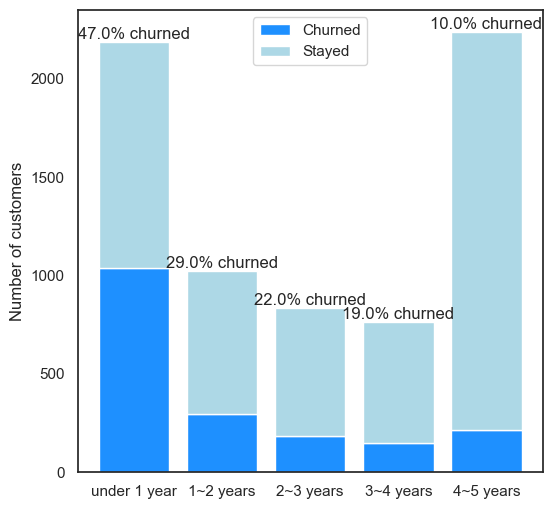

In [104]:
# 가입 기간에 따라 이탈률 시각화
graph_feature_churn_rate_by_class('tenure_class', [0,1,2,3,4],['under 1 year','1~2 years','2~3 years', '3~4 years', '4~5 years'])

- 가입 유지 기간이 1년 이하면 47%의 이탈률에서
- 가입 유지 기간이 길수록 이탈률이 적어지고, 4~5년에는 10%의 이탈률을 보인다.

## 약정 기간에 따른 이탈률

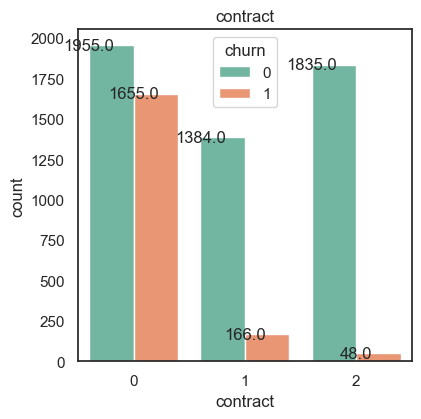

In [130]:
object_col50 = ['contract']

plt.figure(figsize=(25,25))

for i, col in enumerate(object_col50): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")
    
    for p in ax.patches: # 각 막대의 높이를 가져와 텍스트로
        height = p.get_height()
        ax.text(p.get_x(), height, f'{height}', ha="center", va='center')
        
plt.show()

In [132]:
1655/3610

0.4584487534626039

- 0은 Month-to-Month로 약정이 없는 것 / 1은 1년 약정 / 2는 2년 약정
- 약정 없는 고객들의 이탈률이 무려 약 46%로 매우 높다.

# Tenure & Contract 바이닝 해보기
1년 이하  / 1년~2년  /  2년~장기

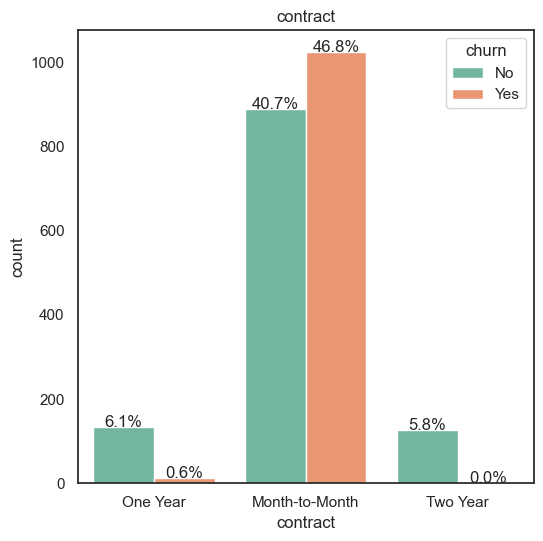

In [170]:
object_col70 = ['contract']

plt.figure(figsize=(20, 20))

for i, col in enumerate(object_col70):
    if col == 'contract':
        filtered_df = df[df['tenure_in_months'] <= 12] # 1년 이하 가입 유지한다면
        # 이런식으로도 특정 컬럼 값만 나오게 할 수 있네?
    else:
        pass
    
    ax = plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='churn', data=filtered_df, palette='Set2')
    ax.set_title(f"{col}")
    
    total = len(filtered_df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, f'{height/total*100:.1f}%', ha="center")

plt.show()

- 1년이하 가입유지기간 고객들은 87% 무약정 고객이고 이탈률이 47%에 달한다.

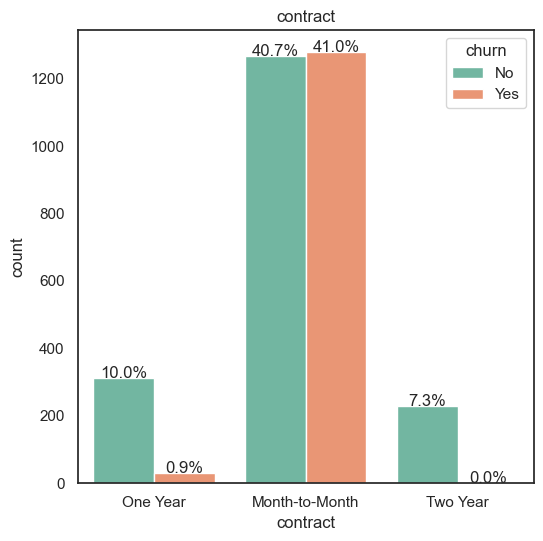

In [171]:
object_col70 = ['contract']

plt.figure(figsize=(20, 20))

for i, col in enumerate(object_col70):
    if col == 'contract':
        filtered_df = df[df['tenure_in_months'] >= 12] # 1년~2년 가입 유지한다면
        filtered_df = df[df['tenure_in_months'] < 24]
        # 이런식으로도 특정 컬럼 값만 나오게 할 수 있네?
    else:
        pass
    
    ax = plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='churn', data=filtered_df, palette='Set2')
    ax.set_title(f"{col}")
    
    total = len(filtered_df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, f'{height/total*100:.1f}%', ha="center")

plt.show()

- 1년 이상 2년 미만도 무약정 고객이 대다수, 이탈률도 높다.

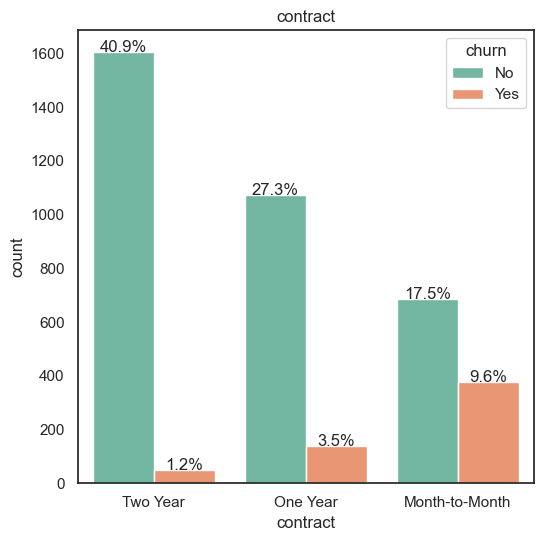

In [173]:
object_col70 = ['contract']

plt.figure(figsize=(20, 20))

for i, col in enumerate(object_col70):
    if col == 'contract':
        filtered_df = df[df['tenure_in_months'] >= 24] # 2년 이상 가입 유지한다면
        # 이런식으로도 특정 컬럼 값만 나오게 할 수 있네?
    else:
        pass
    
    ax = plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='churn', data=filtered_df, palette='Set2')
    ax.set_title(f"{col}")
    
    total = len(filtered_df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, f'{height/total*100:.1f}%', ha="center")

plt.show()

- 2년 이상 장기 고객들은 40%가 2년 약정, 27.3%가 1년 약정인데, 이탈률이 각각 1.2%, 3.5%이다.

## 인사이트5. 인구통계학적 특성에 따른 고객 이탈률

In [101]:
# 나이, 결혼 여부, 성별
# 특히, 나이는 연령대를 정해주어야 함.

In [107]:
df.age.unique()

array([37, 46, 50, 78, 75, 23, 67, 52, 68, 43, 47, 25, 58, 32, 39, 72, 79,
       26, 30, 22, 34, 42, 64, 48, 28, 33, 31, 60, 69, 20, 57, 19, 38, 54,
       35, 51, 66, 61, 24, 55, 59, 71, 49, 40, 21, 45, 29, 62, 76, 77, 73,
       41, 56, 80, 63, 53, 44, 70, 74, 36, 27, 65], dtype=int64)

In [114]:
df_new.columns

Index(['customer_id', 'gender', 'age', 'married', 'number_of_dependents',
       'city', 'zip_code', 'latitude', 'longitude', 'number_of_referrals',
       'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn_category', 'churn_reason',
       'churn', 'tenure_class'],
      dtype='object')

In [117]:
#범주가 두 개가 아닌 3개의 경우를 그리기 위해 가입기간에 따라 함수로 범주 구분
# 함수로했어서 형처럼 3개까지가 최대로 그려주더라
def classify_age(age):
    if age >= 10 and age < 20:
        return 0
    elif age >= 20 and age < 30:
        return 1
    elif age >=30 and age < 40:
        return 2
    elif age >=40 and age < 50:
        return 3
    elif age >=50 and age < 60:
        return 4
    elif age >=60 and age < 70:
        return 5
    return 6
df_new['age'] = df_new['age'].apply(classify_age)
df_new['age'].value_counts().sort_index()

0     127
1    1274
2    1266
3    1342
4    1252
5    1004
6     778
Name: age, dtype: int64

In [118]:
# 인사이트 도출 시 필요한 그래프를 그리기 위한 함수 생성
def graph_feature_churn_rate_by_class(col, classes, classes_desc, figsize=(6, 6), print_info=False):
    churned = []
    stayed = []
    for cls in classes:
        counts = df_new[df_new[col]==cls]["churn"].value_counts()
        churned.append(counts[1])
        stayed.append(counts[0])
    percent_churned = [f"{round(churned[i] / (churned[i] + stayed[i]) * 100, 0)}% churned" for i in range(len(classes))]
    plt.figure(figsize=figsize)
    bar1 = plt.bar(classes_desc, churned, color='dodgerblue')
    bar2 = plt.bar(classes_desc, stayed, bottom=churned, color='lightblue')
    plt.bar_label(bar2, percent_churned)
    plt.ylabel("Number of customers")
    plt.legend(["Churned", "Stayed"])
    plt.show()
    if print_info:
        print(churned, stayed, percent_churned)

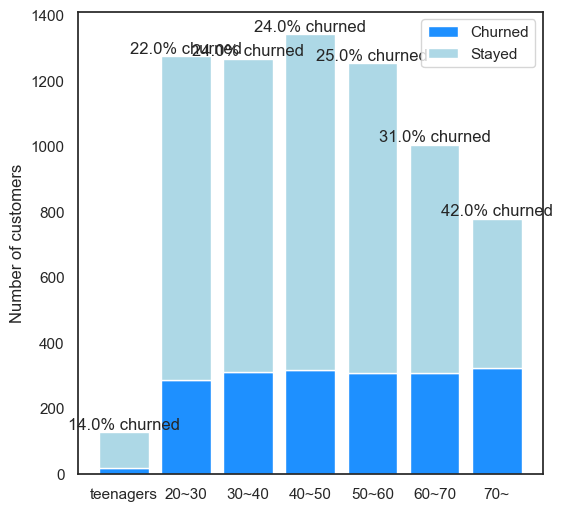

In [121]:
graph_feature_churn_rate_by_class('age', [0,1,2,3,4,5,6],['teenagers','20~30','30~40', '40~50', '50~60','60~70','70~'])

- 40대부터 고연령으로 갈수록 이탈률이 올라간다

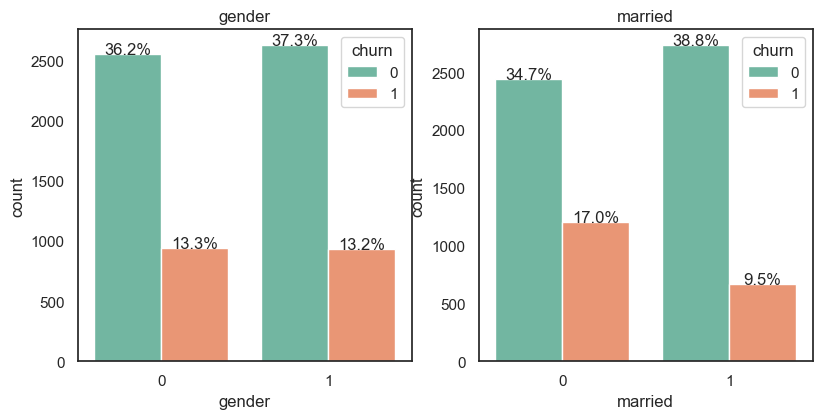

In [109]:
object_col2 = ['gender', 'married'] # 성별과 결혼

plt.figure(figsize=(25,25))

for i, col in enumerate(object_col2): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")
    
    total = len(df)
    for p in ax.patches: # 각 막대의 높이를 가져와 비율을 계산하고 텍스트로
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, f'{height/total*100:.1f}%', ha="center")
        
plt.show()

- 결혼을 안한 사람들이 한 사람들보다 이탈을 더 하는 경향이 있다.

In [142]:
def classify_dep(dep):
    if dep <= 0:
        return 0
    else:
        return 1
df_new['number_of_dependents'] = df_new['number_of_dependents'].apply(classify_dep)
df_new['number_of_dependents'].value_counts().sort_index()

0    5416
1    1627
Name: number_of_dependents, dtype: int64

In [143]:
# 인사이트 도출 시 필요한 그래프를 그리기 위한 함수 생성
def graph_feature_churn_rate_by_class(col, classes, classes_desc, figsize=(6, 6), print_info=False):
    churned = []
    stayed = []
    for cls in classes:
        counts = df_new[df_new[col]==cls]["churn"].value_counts()
        churned.append(counts[1])
        stayed.append(counts[0])
    percent_churned = [f"{round(churned[i] / (churned[i] + stayed[i]) * 100, 0)}% churned" for i in range(len(classes))]
    plt.figure(figsize=figsize)
    bar1 = plt.bar(classes_desc, churned, color='dodgerblue')
    bar2 = plt.bar(classes_desc, stayed, bottom=churned, color='lightblue')
    plt.bar_label(bar2, percent_churned)
    plt.ylabel("Number of customers")
    plt.legend(["Churned", "Stayed"])
    plt.show()
    if print_info:
        print(churned, stayed, percent_churned)

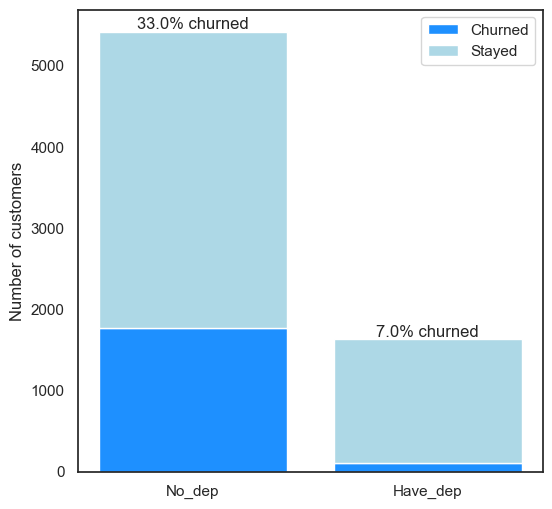

In [144]:
graph_feature_churn_rate_by_class('number_of_dependents', [0,1],['No_dep','Have_dep'])

- 부양가족이 없으면 이탈률이 33% / 부양 가족이 있으면 이탈률 7%

## 인사이트6. Reffaerrals 유무에 따른 이탈률

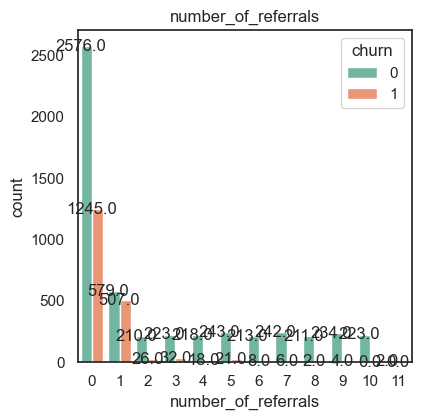

In [141]:
object_col67 = ['number_of_referrals'] 
# 남에게 추천한 적이 있는지 없는지

plt.figure(figsize=(25,25))

for i, col in enumerate(object_col67): # 특정 컬럼 데이터들을 enumerate로 인덱스 번호, 객체 하나씩 담아서 반복문
    ax = plt.subplot(5, 5, i+1) # 0번 컬럼부터 그려주기
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set2') # hue로 그룹 묶어주기
    ax.set_title(f"{col}")
    
    for p in ax.patches: # 각 막대의 높이를 가져와 텍스트로
        height = p.get_height()
        ax.text(p.get_x(), height, f'{height}', ha="center", va='center')
        
plt.show()

In [145]:
def classify_ref(ref):
    if ref <= 0:
        return 0
    else:
        return 1
df_new['number_of_referrals'] = df_new['number_of_referrals'].apply(classify_ref)
df_new['number_of_referrals'].value_counts().sort_index()

0    3821
1    3222
Name: number_of_referrals, dtype: int64

In [146]:
# 인사이트 도출 시 필요한 그래프를 그리기 위한 함수 생성
def graph_feature_churn_rate_by_class(col, classes, classes_desc, figsize=(6, 6), print_info=False):
    churned = []
    stayed = []
    for cls in classes:
        counts = df_new[df_new[col]==cls]["churn"].value_counts()
        churned.append(counts[1])
        stayed.append(counts[0])
    percent_churned = [f"{round(churned[i] / (churned[i] + stayed[i]) * 100, 0)}% churned" for i in range(len(classes))]
    plt.figure(figsize=figsize)
    bar1 = plt.bar(classes_desc, churned, color='dodgerblue')
    bar2 = plt.bar(classes_desc, stayed, bottom=churned, color='lightblue')
    plt.bar_label(bar2, percent_churned)
    plt.ylabel("Number of customers")
    plt.legend(["Churned", "Stayed"])
    plt.show()
    if print_info:
        print(churned, stayed, percent_churned)

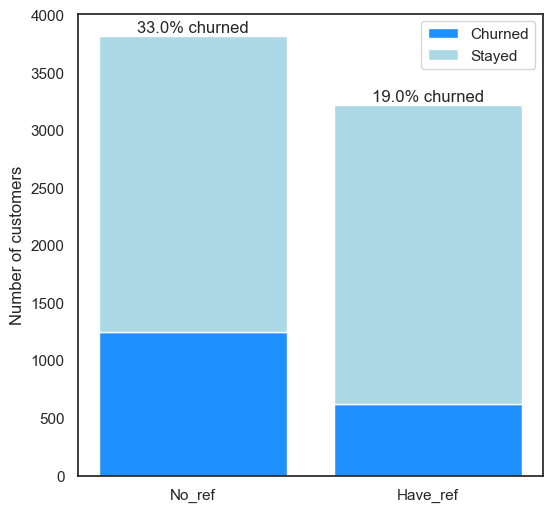

In [147]:
graph_feature_churn_rate_by_class('number_of_referrals', [0,1],['No_ref','Have_ref'])

- 남에게 추천한 적이 있는 고객은 이탈률이 보다 적었다.

## 인사이트7. 하이밸류 고객들의 이탈률 시각화

가입 유지 기간(Tenure)과 총 사용한 요금이 높은 상위 10% 고객들

In [176]:
df['tenure_in_months'].quantile(0.9)

69.0

In [177]:
df['total_revenue'].quantile(0.9)

7642.8060000000005

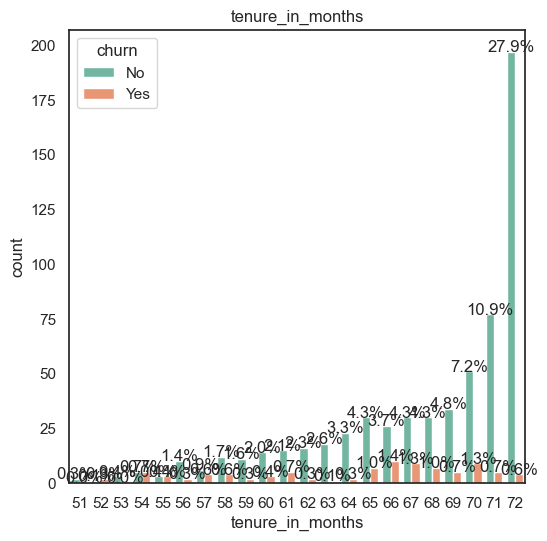

In [182]:
# 둘다 연속형에 unique한 값들이 너무 퍼져있는 상태라

object_col90 = ['tenure_in_months']

plt.figure(figsize=(20, 20))

for i, col in enumerate(object_col90):
    if col == 'tenure_in_months':
        # filtered_df = df[df['tenure_in_months'] >= 69] # 가입유지기간 상위 10%에
        filtered_df = df[df['total_revenue'] >= 7642.8] # 총 사용 요금 상위 10% 둘다 하니까
    else:
        pass
        # 토탈 리베뉴 조건만 충족되었었네?
        
    
    ax = plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='churn', data=filtered_df, palette='Set2')
    ax.set_title(f"{col}")
    
    total = len(filtered_df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, f'{height/total*100:.1f}%', ha="center")

plt.show()

- 가입유지기간 상위 10%에 , 총 사용 요금 상위 10% 둘다 하니까 - 총 사용 요금 조건만 적용됨;
- tenure_in_months 범위가 51부터로 조정되었고, 5년 이상 유지하는 하이밸류 고객들은 이탈률이 거의 없다가 특히 6년째에는 이탈률이 0에 가까움 (6년 이상 쓰면 이탈을 거의 하지 않는다고 예측가능)

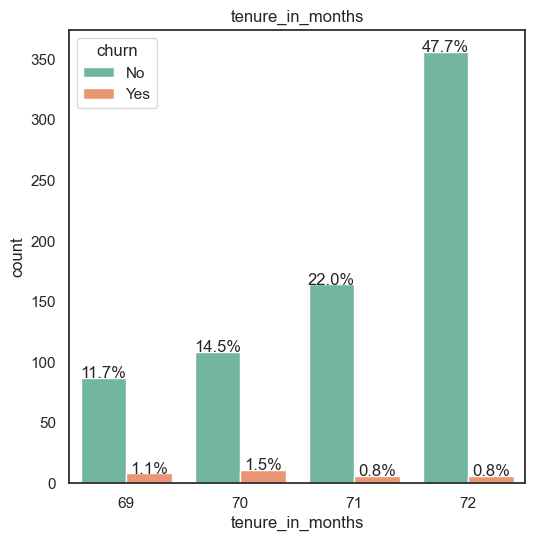

In [185]:
object_col90 = ['tenure_in_months']

plt.figure(figsize=(20, 20))

for i, col in enumerate(object_col90):
    if col == 'tenure_in_months':
         filtered_df = df[df['tenure_in_months'] >= 69]# 총 사용 요금 상위 10% 둘다 하니까
    else:
        pass
        
        
    
    ax = plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='churn', data=filtered_df, palette='Set2')
    ax.set_title(f"{col}")
    
    total = len(filtered_df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, f'{height/total*100:.1f}%', ha="center")

plt.show()

In [187]:
df.total_revenue.describe()
# max가 12000이네

count     7043.000000
mean      3034.379056
std       2865.204542
min         21.360000
25%        605.610000
50%       2108.640000
75%       4801.145000
max      11979.340000
Name: total_revenue, dtype: float64

In [190]:
# object_col90 = ['total_revenue']

# plt.figure(figsize=(20, 20))

# for i, col in enumerate(object_col90):
#     if col == 'total_revenue':
#         filtered_df = df[df['total_revenue'] >= 7642.8] # 총 사용 요금 상위 10% 둘다 하니까
#         filtered_df = df[df['total_revenue'] < 12000]
#     else:
#         pass
        
        
    
#     ax = plt.subplot(3, 3, i+1)
#     sns.countplot(x=col, hue='churn', data=filtered_df, palette='Set2')
#     ax.set_title(f"{col}")
    
#     total = len(filtered_df)
#     for p in ax.patches:
#         height = p.get_height()
#         ax.text(p.get_x() + p.get_width() / 2, height, f'{height/total*100:.1f}%', ha="center")

# plt.show()

In [202]:
group_df = df.groupby('churn')
filtered_df = df[df['total_revenue'] > 7642.8]
filtered_df.groupby('churn')

filtered_df.groupby('churn').describe()

age                                                       \
       count       mean        std   min    25%   50%   75%   max   
churn                                                               
No     614.0  46.874593  17.406443  19.0  32.25  46.0  61.0  80.0   
Yes     91.0  48.461538  18.182597  20.0  32.50  47.0  66.0  80.0   

      number_of_dependents            ... total_long_distance_charges  \
                     count      mean  ...                         75%   
churn                                 ...                               
No                   614.0  0.656352  ...                    2762.625   
Yes                   91.0  0.010989  ...                    2844.435   

               total_revenue                                             \
           max         count         mean         std      min      25%   
churn                                                                     
No     3536.64         614.0  9002.515782  993.494912  7643.51  8179.56   
Yes    3508.82          91.0  8852.978462  918.201827  7665.20  8152.42   

                                    
            50%      75%       max  
churn                               
No     8776.075  9718.23  11979.34  
Yes    8614.800  9316.31  11195.44  

[2 rows x 120 columns]

In [204]:
91/705ㄴ

0.12907801418439716

시각화가 안되어서 결국 저렇게 describe로 표현
- 총 사용 금액이 7642.8$인 상위 10% 고객들은 12%의 이탈률을 가지고 있었다.

- ABECE 마케팅은 결국 각각 뭔 마케팅을 썼는지 알수가없으니까 인사이트 뽑을 수 없음

### 데이터 인코딩

원핫인코딩을 쓰면 좋을지 라벨 인코딩을 쓰면 좋을지

라벨 인코딩으로 결정

데이터 인코딩 후 상관관계 확인, 컬럼 선정하여 훈련세트와 테스트 세트 나눠 모델 학습

In [41]:
# 라벨 인코딩을 적용할 변수의 리스트 : object_col

# fit()과 transform()으로 라벨 인코딩을 수행
for feature in object_col:
    # LabelEncoder를 객체로 생성
    encoder = LabelEncoder()
    # fit, transform 메소드를 통한 레이블 인코딩
    encoder.fit(df[feature])
    df[feature] = encoder.transform(df[feature])

In [44]:
# 컬럼 삭제
df=df.drop(columns=['customer_id','churn_category','churn_reason', 'total_refunds'])